# Моделирование NVT ансамбля <a class="tocSkip">

   - Система: $N = 1372$ частиц;
   - Ячейка моделирования: $V = 12.25\sigma\times12.25\sigma\times12.25\sigma$;
   - Потенциал взаимодействия: Леннард-Джонс;
   - Ансамбль: $NVT$;
   - Начальная температура: $T_i = 1.0~\varepsilon / k_B$;
   - Конечная температура: $T_f = 10^{-4}~\varepsilon / k_B$;
   - Скорости охлаждения: $\gamma = 0.02~\varepsilon / k_B\tau$;
   - Термостат: масштабирование скоростей;
   - Толщина сферического слоя (список Верле): $\Delta r_s = 0.3~\sigma$;
   - Временной шаг: $\Delta t = 0.005~\tau$;
   - Число "неравновесных" итераций: $40000$;
   - Равновесные характеристики системы рассчитывалась через каждые $2000$ шагов;
   - Число шагов на уравновешивание системы при фиксированных внешних условиях: $M=15000$;
   - Число ансамблей $N=5000$;
   - Усреднение по ансамблям при фиксированных внешних условиях: $2N-1$ шагов (к первому ансамблю относятся шаги с $1$ по $N$ шаг, ко второму - с $2$ по $N+1$ и т. д.);
   - Функция радиального распределения вычислялась как среднее по времени за первые $N$ шагов;

## Предварительные настройки

### Импорт необходимых библиотек, классов и функций

In [1]:
from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

In [2]:
from collections import Counter
from copy import deepcopy
from datetime import datetime
import os
import sys

from math import log10

In [3]:
from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
sys.path.append(os.path.dirname(sys.path[0]))

import scripts.constants as con
from scripts.plotter import Plotter, get_temperature_legend
import scripts.postprocessing as pp

%autoreload 2

In [5]:
COLORS = (
    'black',
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'purple',
    'orange',
    'olive',
    'yellow',
    'brown',
    'pink',
    'gray',
    'lime',
    'slateblue',
    'crimson',
    'darkviolet',
    'sienna',
    'coral',
    'navy',
    'crimson',
    'goldenrod',
    'darkcyan',
    'dodgerblue',
    'saddlebrown',
)

default_cycler = cycler(color=COLORS)

plt.rc('axes', prop_cycle=default_cycler)

print(f'{len(COLORS)} colors are acceptable.')

25 colors are acceptable.


### Пути к файлам

In [6]:
CURRENT_DATA_SLOW = '2021-06-12_cooling_normal'
PLOT_FILENAME_POSTFIX_SLOW = 'cooling_slow'

In [7]:
PATH_TO_CURRENT_DATA_SLOW = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_SLOW)
PATH_TO_CURRENT_DATA_SLOW

'C:\\albert\\git_reps\\molecular_dynamics\\data\\2021-06-12_cooling_normal'

In [8]:
PATH_TO_CURRENT_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA_SLOW)
PATH_TO_CURRENT_PLOTS

'C:\\albert\\git_reps\\molecular_dynamics\\plots\\2021-06-12_cooling_normal'

### Пользовательские функции

In [9]:
def get_merged_data(
    old_data: pd.DataFrame,
    data_filename_prefix: str,
    merge_column_name: str,
    old_column_name: str,
    temperature: float,
    columns: list = None,
):
    df = pd.read_csv(
        f'{data_filename_prefix}{temperature:.5f}.csv',
        sep=';',
    )
    if columns is not None:
        df = df[columns]
    merged_data = old_data.merge(
        right=df,
        how='outer',
        on=merge_column_name,
    )
    merged_data = merged_data.rename(
        columns={old_column_name: f'{temperature:.5f}'})
    return merged_data

In [10]:
def save_plot(filename):
    _filename = filename
    if filename.endswith('.png'):
        _filename = _filename.removesuffix('.png')
    if filename.endswith('.eps'):
        _filename = _filename.removesuffix('.eps')
    
    plt.savefig(os.path.join(PATH_TO_CURRENT_PLOTS, f'{_filename}.png'))
    plt.savefig(os.path.join(PATH_TO_CURRENT_PLOTS, f'{_filename}.eps'))

## Параметры системы

In [11]:
setups_slow = []
rdf_slow = pp.RadialDistributionFunctionPP(path_to_data=PATH_TO_CURRENT_DATA_SLOW)

for filename in os.listdir(PATH_TO_CURRENT_DATA_SLOW)[::+1]:
    if filename.startswith('rdf') and filename.endswith('csv'):
        parts = filename[:-4].split('_')
        setup = {
            'temperature': float(parts[2]),
            'pressure': float(parts[4]) if 'P' in parts else None,
            'heating_velocity': float(parts[6]) if 'HV' in parts else None,
        }
        setups_slow.append(setup)
        print(setup)
        filename_postfix = pp.get_filename_postfix(setup)
        rdf_slow.append(filename_postfix=filename_postfix)
        rdf_slow.rename_column(column_name='rdf', setup_number=len(setups_slow) - 1)

rdf_slow.data

{'temperature': 1e-05, 'pressure': -0.45718, 'heating_velocity': 0.02}
{'temperature': 1e-05, 'pressure': -0.46743, 'heating_velocity': 0.02}
{'temperature': 1e-05, 'pressure': -0.47041, 'heating_velocity': 0.02}
{'temperature': 1e-05, 'pressure': -0.49212, 'heating_velocity': 0.02}
{'temperature': 1e-05, 'pressure': -0.49368, 'heating_velocity': 0.02}
{'temperature': 1e-05, 'pressure': -0.49452, 'heating_velocity': 0.02}
{'temperature': 1e-05, 'pressure': -0.49804, 'heating_velocity': 0.02}
{'temperature': 1e-05, 'pressure': -0.50018, 'heating_velocity': 0.02}
{'temperature': 1e-05, 'pressure': -0.50655, 'heating_velocity': 0.02}
{'temperature': 1e-05, 'pressure': -0.50785, 'heating_velocity': 0.02}
{'temperature': 1e-05, 'pressure': -0.50786, 'heating_velocity': 0.02}
{'temperature': 1e-05, 'pressure': -0.50805, 'heating_velocity': 0.02}
{'temperature': 1e-05, 'pressure': -0.50899, 'heating_velocity': 0.02}
{'temperature': 1e-05, 'pressure': -0.51047, 'heating_velocity': 0.02}
{'temp

radius   setup_0   setup_1   setup_2   setup_3   setup_4   setup_5  \
0      0.01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1      0.02  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2      0.03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.04  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.05  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
..      ...       ...       ...       ...       ...       ...       ...   
607    6.08  0.985670  0.985271  1.001978  0.948627  0.975434  0.992216   
608    6.09  1.023982  1.015591  1.010337  0.933350  0.969631  0.973317   
609    6.10  1.004326  0.981849  0.999750  0.988910  0.947478  0.940717   
610    6.11  0.982700  1.006187  1.003358  0.942479  0.958195  0.966708   
611    6.12  0.995502  0.989484  1.020724  0.964883  0.959526  0.984541   

      setup_6   setup_7   setup_8  ...  setup_75  setup_76  setup_77  \
0    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
2    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
3    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
4    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
..        ...       ...       ...  ...       ...       ...       ...   
607  0.947413  0.940272  0.971314  ...  0.955265  0.945690  0.975932   
608  0.965295  0.983166  0.985711  ...  0.961569  0.955264  0.973686   
609  0.966540  0.969208  0.956070  ...  0.962399  0.966713  0.975217   
610  0.944751  0.979258  0.961287  ...  0.959814  0.975111  0.974024   
611  0.930868  0.977456  0.982176  ...  0.962362  0.979229  0.975089   

     setup_78  setup_79  setup_80  setup_81  setup_82  setup_83  setup_84  
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
..        ...       ...       ...       ...       ...       ...       ...  
607  0.962204  0.963831  0.988789  1.004782  1.003279  1.003416  1.001866  
608  0.960569  0.963117  0.987367  1.005121  1.002428  1.004325  1.001126  
609  0.963331  0.963416  0.986575  1.004245  1.001173  1.005989  1.002900  
610  0.960998  0.963572  0.983743  1.002158  1.001337  1.005308  1.002061  
611  0.959479  0.962114  0.983230  1.000448  0.999344  1.004321  1.002876  

[612 rows x 86 columns]

## Функция радиального распределения $g(\textbf{r})$ при различных температурах

$$g(\textbf{r})=\dfrac{V}{N^2}\left<\sum_{i}{\sum_{j\ne i}{\delta(\textbf{r}-\textbf{r}_{ij})}}\right>$$

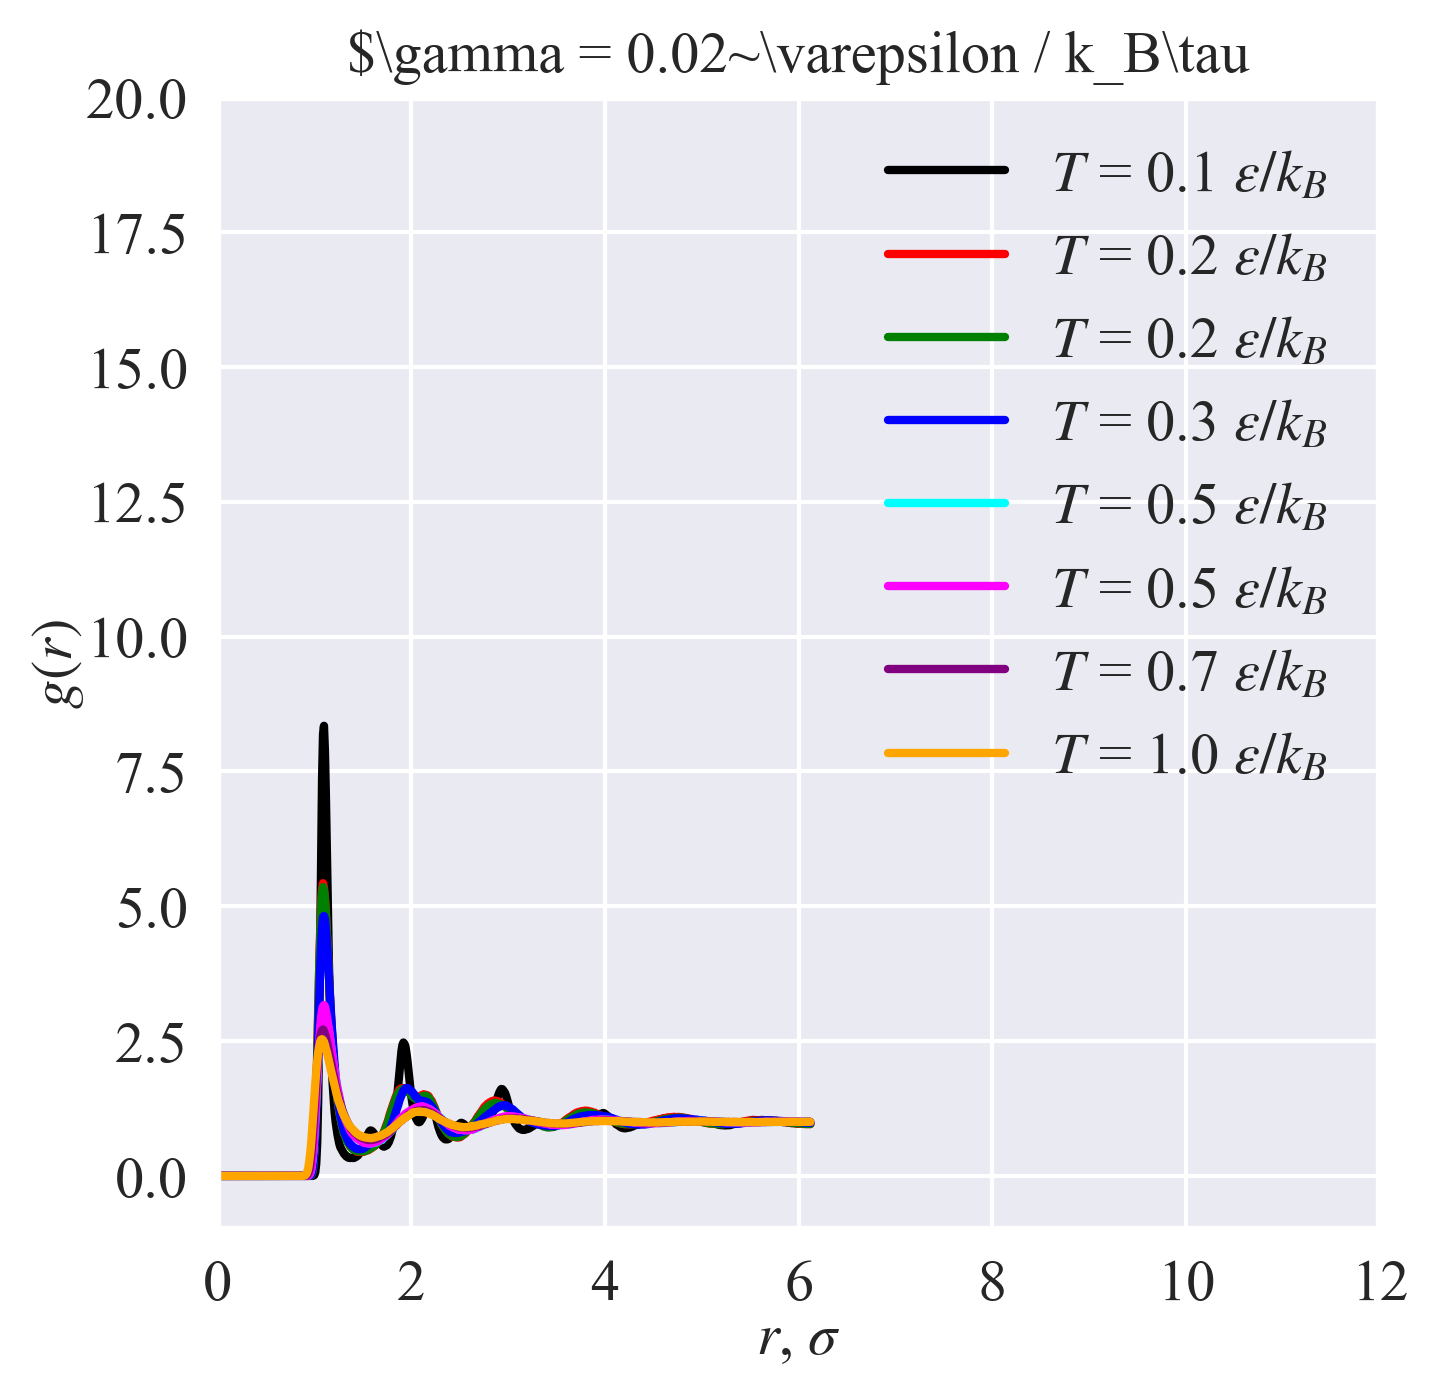

In [12]:
plotter = Plotter(
    path_to_plots=PATH_TO_CURRENT_PLOTS,
    limits=dict(
        left=0,
        right=12,
        bottom=-1,
        top=20,
    ),
    size=(5, 5),
    labels=('radius', 'rdf'),
)

shown=list(range(len(setups_slow)))[-8:]
shift = 0
for i, setup in enumerate(setups_slow):
    if shown is not None and i not in shown:
        continue
    plotter.ax.plot(
        rdf_slow.data['radius'],
        (rdf_slow.data[f'setup_{i}'] + shift * (len(setups_slow) - (i + 1))),
        label=get_temperature_legend(setup["temperature"], accuracy=1),
        color=COLORS[i - shown[0]],
    )

plotter.get_legend()
plotter.save_plot(filename=f'rdf_{PLOT_FILENAME_POSTFIX_SLOW}.png')
plotter.set_title(r'$\gamma = 0.02~\varepsilon / k_B\tau')
plt.show()

## Таблица значений RDF

In [13]:
rdf_table = rdf_slow.get_rdf_table()
rdf_table

radius    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.10  ...  \
setup_84   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_83   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_82   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_81   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_80   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
setup_4    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_3    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_2    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_1    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
setup_0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

radius        6.03      6.04      6.05      6.06      6.07      6.08  \
setup_84  1.002733  1.002386  1.003577  1.003602  1.002374  1.001866   
setup_83  1.002259  1.003357  1.003939  1.003055  1.003582  1.003416   
setup_82  1.004956  1.002419  1.003493  1.003179  1.003693  1.003279   
setup_81  1.007688  1.006051  1.007214  1.005589  1.003792  1.004782   
setup_80  0.994478  0.994103  0.992023  0.991514  0.987566  0.988789   
...            ...       ...       ...       ...       ...       ...   
setup_4   0.992668  0.947724  0.959802  0.942577  0.965160  0.975434   
setup_3   0.968368  0.970620  0.970588  0.931126  0.961910  0.948627   
setup_2   0.868392  0.873289  0.922003  0.909520  0.954967  1.001978   
setup_1   0.859229  0.878507  0.875266  0.896518  0.949257  0.985271   
setup_0   0.837900  0.888607  0.884006  0.894361  0.933887  0.985670   

radius        6.09      6.10      6.11      6.12  
setup_84  1.001126  1.002900  1.002061  1.002876  
setup_83  1.004325  1.005989  1.005308  1.004321  
setup_82  1.002428  1.001173  1.001337  0.999344  
setup_81  1.005121  1.004245  1.002158  1.000448  
setup_80  0.987367  0.986575  0.983743  0.983230  
...            ...       ...       ...       ...  
setup_4   0.969631  0.947478  0.958195  0.959526  
setup_3   0.933350  0.988910  0.942479  0.964883  
setup_2   1.010337  0.999750  1.003358  1.020724  
setup_1   1.015591  0.981849  1.006187  0.989484  
setup_0   1.023982  1.004326  0.982700  0.995502  

[85 rows x 612 columns]

## Температура системы как признак модели

In [14]:
temperatures = np.array([
    setups_slow[value]['temperature']
    for value
    in rdf_table.index.str[6:].values.astype(np.int32)
])
samples = temperatures[:, np.newaxis]
samples

array([[9.9952e-01],
       [7.4903e-01],
       [4.9971e-01],
       [4.9929e-01],
       [2.9979e-01],
       [2.4974e-01],
       [2.4900e-01],
       [9.9860e-02],
       [5.0360e-02],
       [4.9880e-02],
       [3.0000e-05],
       [3.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [2.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.0000e-05],
       [1.000

In [15]:
np.random.seed(0)
samples_indices = np.arange(samples.shape[0])
np.random.shuffle(samples_indices)
samples_train_indices = samples_indices[:samples_indices.size // 2]
samples_test_indices = samples_indices[samples_indices.size // 2:]

train_samples = samples[samples_train_indices]
test_samples = samples[samples_test_indices]

samples_train_indices, samples_test_indices

(array([ 2, 13, 63, 41, 48, 30, 50, 76, 55, 43,  7, 26, 33, 60,  8, 16, 24,
        54, 62, 74, 22,  6, 42, 66, 80, 52, 69, 75, 78,  3, 59, 45, 27, 18,
        73, 84, 56, 53,  4, 15, 17, 40]),
 array([38,  5, 77, 71,  0, 34, 28, 11, 35, 23, 10, 31, 57, 68,  1, 32, 72,
        14, 61, 19, 29, 51, 49, 82, 83, 20, 79, 25, 37, 46, 39, 65, 58, 12,
        70, 36, 21,  9, 81, 67, 64, 47, 44]))

In [16]:
train_samples, test_samples

(array([[4.9971e-01],
        [2.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [9.9860e-02],
        [2.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [5.0360e-02],
        [2.0000e-05],
        [2.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [2.0000e-05],
        [2.4900e-01],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [4.9929e-01],
        [1.0000e-05],
        [1.0000e-05],
        [2.0000e-05],
        [2.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [1.0000e-05],
        [2.9979e-01],
        [2.0000e-05],
        [2.0000e-05],
        [1.0000e-05]]),
 array([[1.0000e-05],
        [2.4974e-01],
        [1.0000e-05],
        

## Настройка гиперпараметров

In [17]:
regressors = {
    'linear': LinearRegression(), 
    'k_neighbors_uniform': KNeighborsRegressor(weights='uniform'), 
    'k_neighbors_distance': KNeighborsRegressor(weights='distance'), 
    'r_neighbors_uniform': RadiusNeighborsRegressor(weights='uniform'), 
    'r_neighbors_distance': RadiusNeighborsRegressor(weights='distance'), 
    'decision_tree': DecisionTreeRegressor(),
}
scores = {key: [] for key in regressors.keys()}
param_names = {
    'k_neighbors_uniform': 'n_neighbors', 
    'k_neighbors_distance': 'n_neighbors', 
    'r_neighbors_uniform': 'radius', 
    'r_neighbors_distance': 'radius',
    'decision_tree': 'max_depth',
}
param_ranges = {
    'k_neighbors_uniform': np.arange(1, 15),
    'k_neighbors_distance': np.arange(1, 15),
    'r_neighbors_uniform': np.linspace(0.4, 1.3, 10),
    'r_neighbors_distance': np.linspace(0.4, 1.3, 10),
    'decision_tree': np.arange(1, 15),
}

for i, column in enumerate(rdf_table.columns):
    print(f'Step: {i + 1} / {rdf_table.columns.shape[0]}')
    train_targets = rdf_table[column].values[samples_train_indices]
    if not train_targets.any():
        continue
    for key in list(regressors.keys())[1:]:
        _, test_scores = validation_curve(
            regressors[key],
            train_samples, train_targets,
            param_name=param_names[key],
            param_range=np.arange(1, 9),
            scoring='neg_mean_squared_error',
            cv=train_samples.shape[0],
        )
        scores[key].append(np.mean(test_scores, axis=1).argmax())

best_hyperparameters = {}
for key, value in scores.items():
    if value:
        best_hyperparameters[key] = param_ranges[key][
            Counter(value).most_common(1)[0][0]
        ]
        
best_hyperparameters

Step: 1 / 612
Step: 2 / 612
Step: 3 / 612
Step: 4 / 612
Step: 5 / 612
Step: 6 / 612
Step: 7 / 612
Step: 8 / 612
Step: 9 / 612
Step: 10 / 612
Step: 11 / 612
Step: 12 / 612
Step: 13 / 612
Step: 14 / 612
Step: 15 / 612
Step: 16 / 612
Step: 17 / 612
Step: 18 / 612
Step: 19 / 612
Step: 20 / 612
Step: 21 / 612
Step: 22 / 612
Step: 23 / 612
Step: 24 / 612
Step: 25 / 612
Step: 26 / 612
Step: 27 / 612
Step: 28 / 612
Step: 29 / 612
Step: 30 / 612
Step: 31 / 612
Step: 32 / 612
Step: 33 / 612
Step: 34 / 612
Step: 35 / 612
Step: 36 / 612
Step: 37 / 612
Step: 38 / 612
Step: 39 / 612
Step: 40 / 612
Step: 41 / 612
Step: 42 / 612
Step: 43 / 612
Step: 44 / 612
Step: 45 / 612
Step: 46 / 612
Step: 47 / 612
Step: 48 / 612
Step: 49 / 612
Step: 50 / 612
Step: 51 / 612
Step: 52 / 612
Step: 53 / 612
Step: 54 / 612
Step: 55 / 612
Step: 56 / 612
Step: 57 / 612
Step: 58 / 612
Step: 59 / 612
Step: 60 / 612
Step: 61 / 612
Step: 62 / 612
Step: 63 / 612
Step: 64 / 612
Step: 65 / 612
Step: 66 / 612
Step: 67 / 612
Step

Step: 520 / 612
Step: 521 / 612
Step: 522 / 612
Step: 523 / 612
Step: 524 / 612
Step: 525 / 612
Step: 526 / 612
Step: 527 / 612
Step: 528 / 612
Step: 529 / 612
Step: 530 / 612
Step: 531 / 612
Step: 532 / 612
Step: 533 / 612
Step: 534 / 612
Step: 535 / 612
Step: 536 / 612
Step: 537 / 612
Step: 538 / 612
Step: 539 / 612
Step: 540 / 612
Step: 541 / 612
Step: 542 / 612
Step: 543 / 612
Step: 544 / 612
Step: 545 / 612
Step: 546 / 612
Step: 547 / 612
Step: 548 / 612
Step: 549 / 612
Step: 550 / 612
Step: 551 / 612
Step: 552 / 612
Step: 553 / 612
Step: 554 / 612
Step: 555 / 612
Step: 556 / 612
Step: 557 / 612
Step: 558 / 612
Step: 559 / 612
Step: 560 / 612
Step: 561 / 612
Step: 562 / 612
Step: 563 / 612
Step: 564 / 612
Step: 565 / 612
Step: 566 / 612
Step: 567 / 612
Step: 568 / 612
Step: 569 / 612
Step: 570 / 612
Step: 571 / 612
Step: 572 / 612
Step: 573 / 612
Step: 574 / 612
Step: 575 / 612
Step: 576 / 612
Step: 577 / 612
Step: 578 / 612
Step: 579 / 612
Step: 580 / 612
Step: 581 / 612
Step: 58

{'k_neighbors_uniform': 4,
 'k_neighbors_distance': 4,
 'r_neighbors_uniform': 0.4,
 'r_neighbors_distance': 0.4,
 'decision_tree': 1}

## Обучение модели

In [19]:
regressors_list = []
scores_dict = {
    'linear': [],
    'k_neighbors_uniform': [],
    'k_neighbors_distance': [],
    'r_neighbors_uniform': [],
    'r_neighbors_distance': [],
    'decision_tree': [],
}

for i, column in enumerate(rdf_table.columns):
    print(f'Step: {i + 1} / {rdf_table.columns.shape[0]}')
    train_targets = rdf_table[column].values[samples_train_indices]
    regressors = {
        'linear': LinearRegression(),
        'k_neighbors_uniform': KNeighborsRegressor(n_neighbors=4, weights='uniform'),
        'k_neighbors_distance': KNeighborsRegressor(n_neighbors=4, weights='distance'),
        'r_neighbors_uniform': RadiusNeighborsRegressor(radius=0.4, weights='uniform'),
        'r_neighbors_distance': RadiusNeighborsRegressor(radius=0.4, weights='distance'),
        'decision_tree': DecisionTreeRegressor(max_depth=1,),
    }
    for key, value in regressors.items():
        score = cross_val_score(
            value, 
            train_samples, train_targets,
            scoring='neg_mean_squared_error',
            cv=train_samples.shape[0],
        ).mean()
        scores_dict[key].append(score)
        regressors[key].fit(train_samples, train_targets)
    regressors_list.append(regressors)

for key, value in scores_dict.items():
    scores_dict[key] = np.array(value)

Step: 1 / 612
Step: 2 / 612
Step: 3 / 612
Step: 4 / 612
Step: 5 / 612
Step: 6 / 612
Step: 7 / 612
Step: 8 / 612
Step: 9 / 612
Step: 10 / 612
Step: 11 / 612
Step: 12 / 612
Step: 13 / 612
Step: 14 / 612
Step: 15 / 612
Step: 16 / 612
Step: 17 / 612
Step: 18 / 612
Step: 19 / 612
Step: 20 / 612
Step: 21 / 612
Step: 22 / 612
Step: 23 / 612
Step: 24 / 612
Step: 25 / 612
Step: 26 / 612
Step: 27 / 612
Step: 28 / 612
Step: 29 / 612
Step: 30 / 612
Step: 31 / 612
Step: 32 / 612
Step: 33 / 612
Step: 34 / 612
Step: 35 / 612
Step: 36 / 612
Step: 37 / 612
Step: 38 / 612
Step: 39 / 612
Step: 40 / 612
Step: 41 / 612
Step: 42 / 612
Step: 43 / 612
Step: 44 / 612
Step: 45 / 612
Step: 46 / 612
Step: 47 / 612
Step: 48 / 612
Step: 49 / 612
Step: 50 / 612
Step: 51 / 612
Step: 52 / 612
Step: 53 / 612
Step: 54 / 612
Step: 55 / 612
Step: 56 / 612
Step: 57 / 612
Step: 58 / 612
Step: 59 / 612
Step: 60 / 612
Step: 61 / 612
Step: 62 / 612
Step: 63 / 612
Step: 64 / 612
Step: 65 / 612
Step: 66 / 612
Step: 67 / 612
Step

Step: 520 / 612
Step: 521 / 612
Step: 522 / 612
Step: 523 / 612
Step: 524 / 612
Step: 525 / 612
Step: 526 / 612
Step: 527 / 612
Step: 528 / 612
Step: 529 / 612
Step: 530 / 612
Step: 531 / 612
Step: 532 / 612
Step: 533 / 612
Step: 534 / 612
Step: 535 / 612
Step: 536 / 612
Step: 537 / 612
Step: 538 / 612
Step: 539 / 612
Step: 540 / 612
Step: 541 / 612
Step: 542 / 612
Step: 543 / 612
Step: 544 / 612
Step: 545 / 612
Step: 546 / 612
Step: 547 / 612
Step: 548 / 612
Step: 549 / 612
Step: 550 / 612
Step: 551 / 612
Step: 552 / 612
Step: 553 / 612
Step: 554 / 612
Step: 555 / 612
Step: 556 / 612
Step: 557 / 612
Step: 558 / 612
Step: 559 / 612
Step: 560 / 612
Step: 561 / 612
Step: 562 / 612
Step: 563 / 612
Step: 564 / 612
Step: 565 / 612
Step: 566 / 612
Step: 567 / 612
Step: 568 / 612
Step: 569 / 612
Step: 570 / 612
Step: 571 / 612
Step: 572 / 612
Step: 573 / 612
Step: 574 / 612
Step: 575 / 612
Step: 576 / 612
Step: 577 / 612
Step: 578 / 612
Step: 579 / 612
Step: 580 / 612
Step: 581 / 612
Step: 58

## Визуализация ошибок

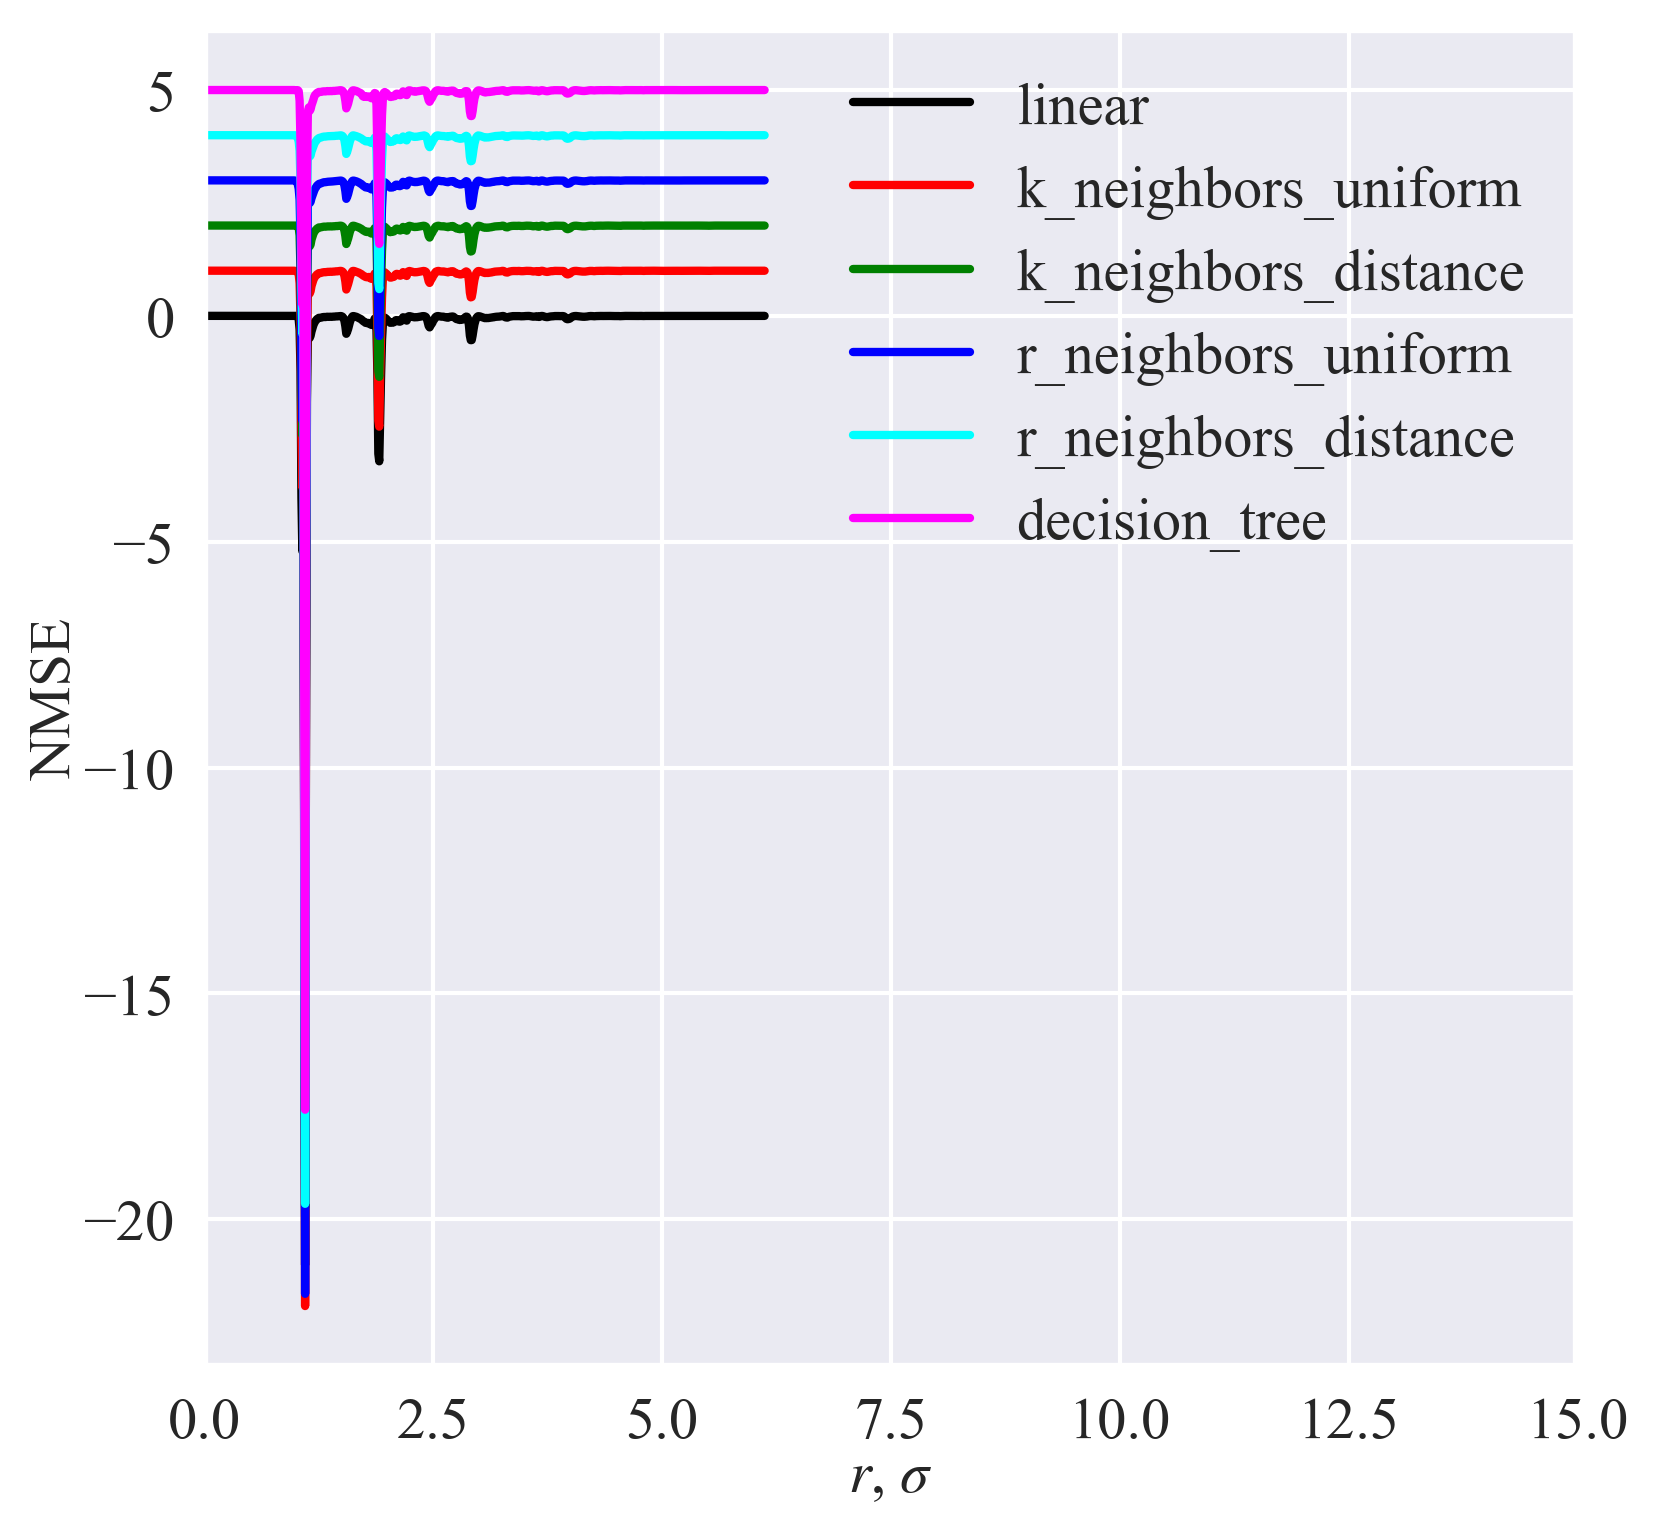

In [20]:
i = 0
for key, value in scores_dict.items():
    plt.plot(
        rdf_slow.data['radius'],
        value + i, label=key, 
        color=COLORS[i],
    )
    i += 1
plt.legend()
plt.xlim(
    left=0.0,
    right=15,
)
plt.ylim(
    #     top=0.01,
    #     bottom=-0.25,
)
plt.xlabel(r'$r$, $\sigma $')
plt.ylabel('NMSE')
save_plot('mse_after_cv')

In [21]:
predicted_temperatures = np.array(test_samples)

predicted_rdf_points = {
    regressor: {key: [] for key in predicted_temperatures[:, 0]}
    for regressor in scores_dict.keys()
}

for item in regressors_list:
    for key, value in item.items():
        predicted_data = value.predict(predicted_temperatures)
        for _key, _ in predicted_rdf_points[key].items():
            predicted_rdf_points[key][_key].append(
                predicted_data[np.where(predicted_temperatures[:, 0] == _key)][0]
            )

for key, value in predicted_rdf_points.items():
    for _key, _value in value.items():
        predicted_rdf_points[key][_key] = np.array(_value)

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\User\Envs\md_env\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predic

In [22]:
for i, temperature in zip(samples_test_indices, predicted_temperatures):
    print(i, temperature[0])

38 1e-05
5 0.24974
77 1e-05
71 1e-05
0 0.99952
34 1e-05
28 2e-05
11 3e-05
35 1e-05
23 2e-05
10 3e-05
31 1e-05
57 1e-05
68 1e-05
1 0.74903
32 1e-05
72 1e-05
14 2e-05
61 1e-05
19 2e-05
29 1e-05
51 1e-05
49 1e-05
82 1e-05
83 1e-05
20 2e-05
79 1e-05
25 2e-05
37 1e-05
46 1e-05
39 1e-05
65 1e-05
58 1e-05
12 2e-05
70 1e-05
36 1e-05
21 2e-05
9 0.04988
81 1e-05
67 1e-05
64 1e-05
47 1e-05
44 1e-05


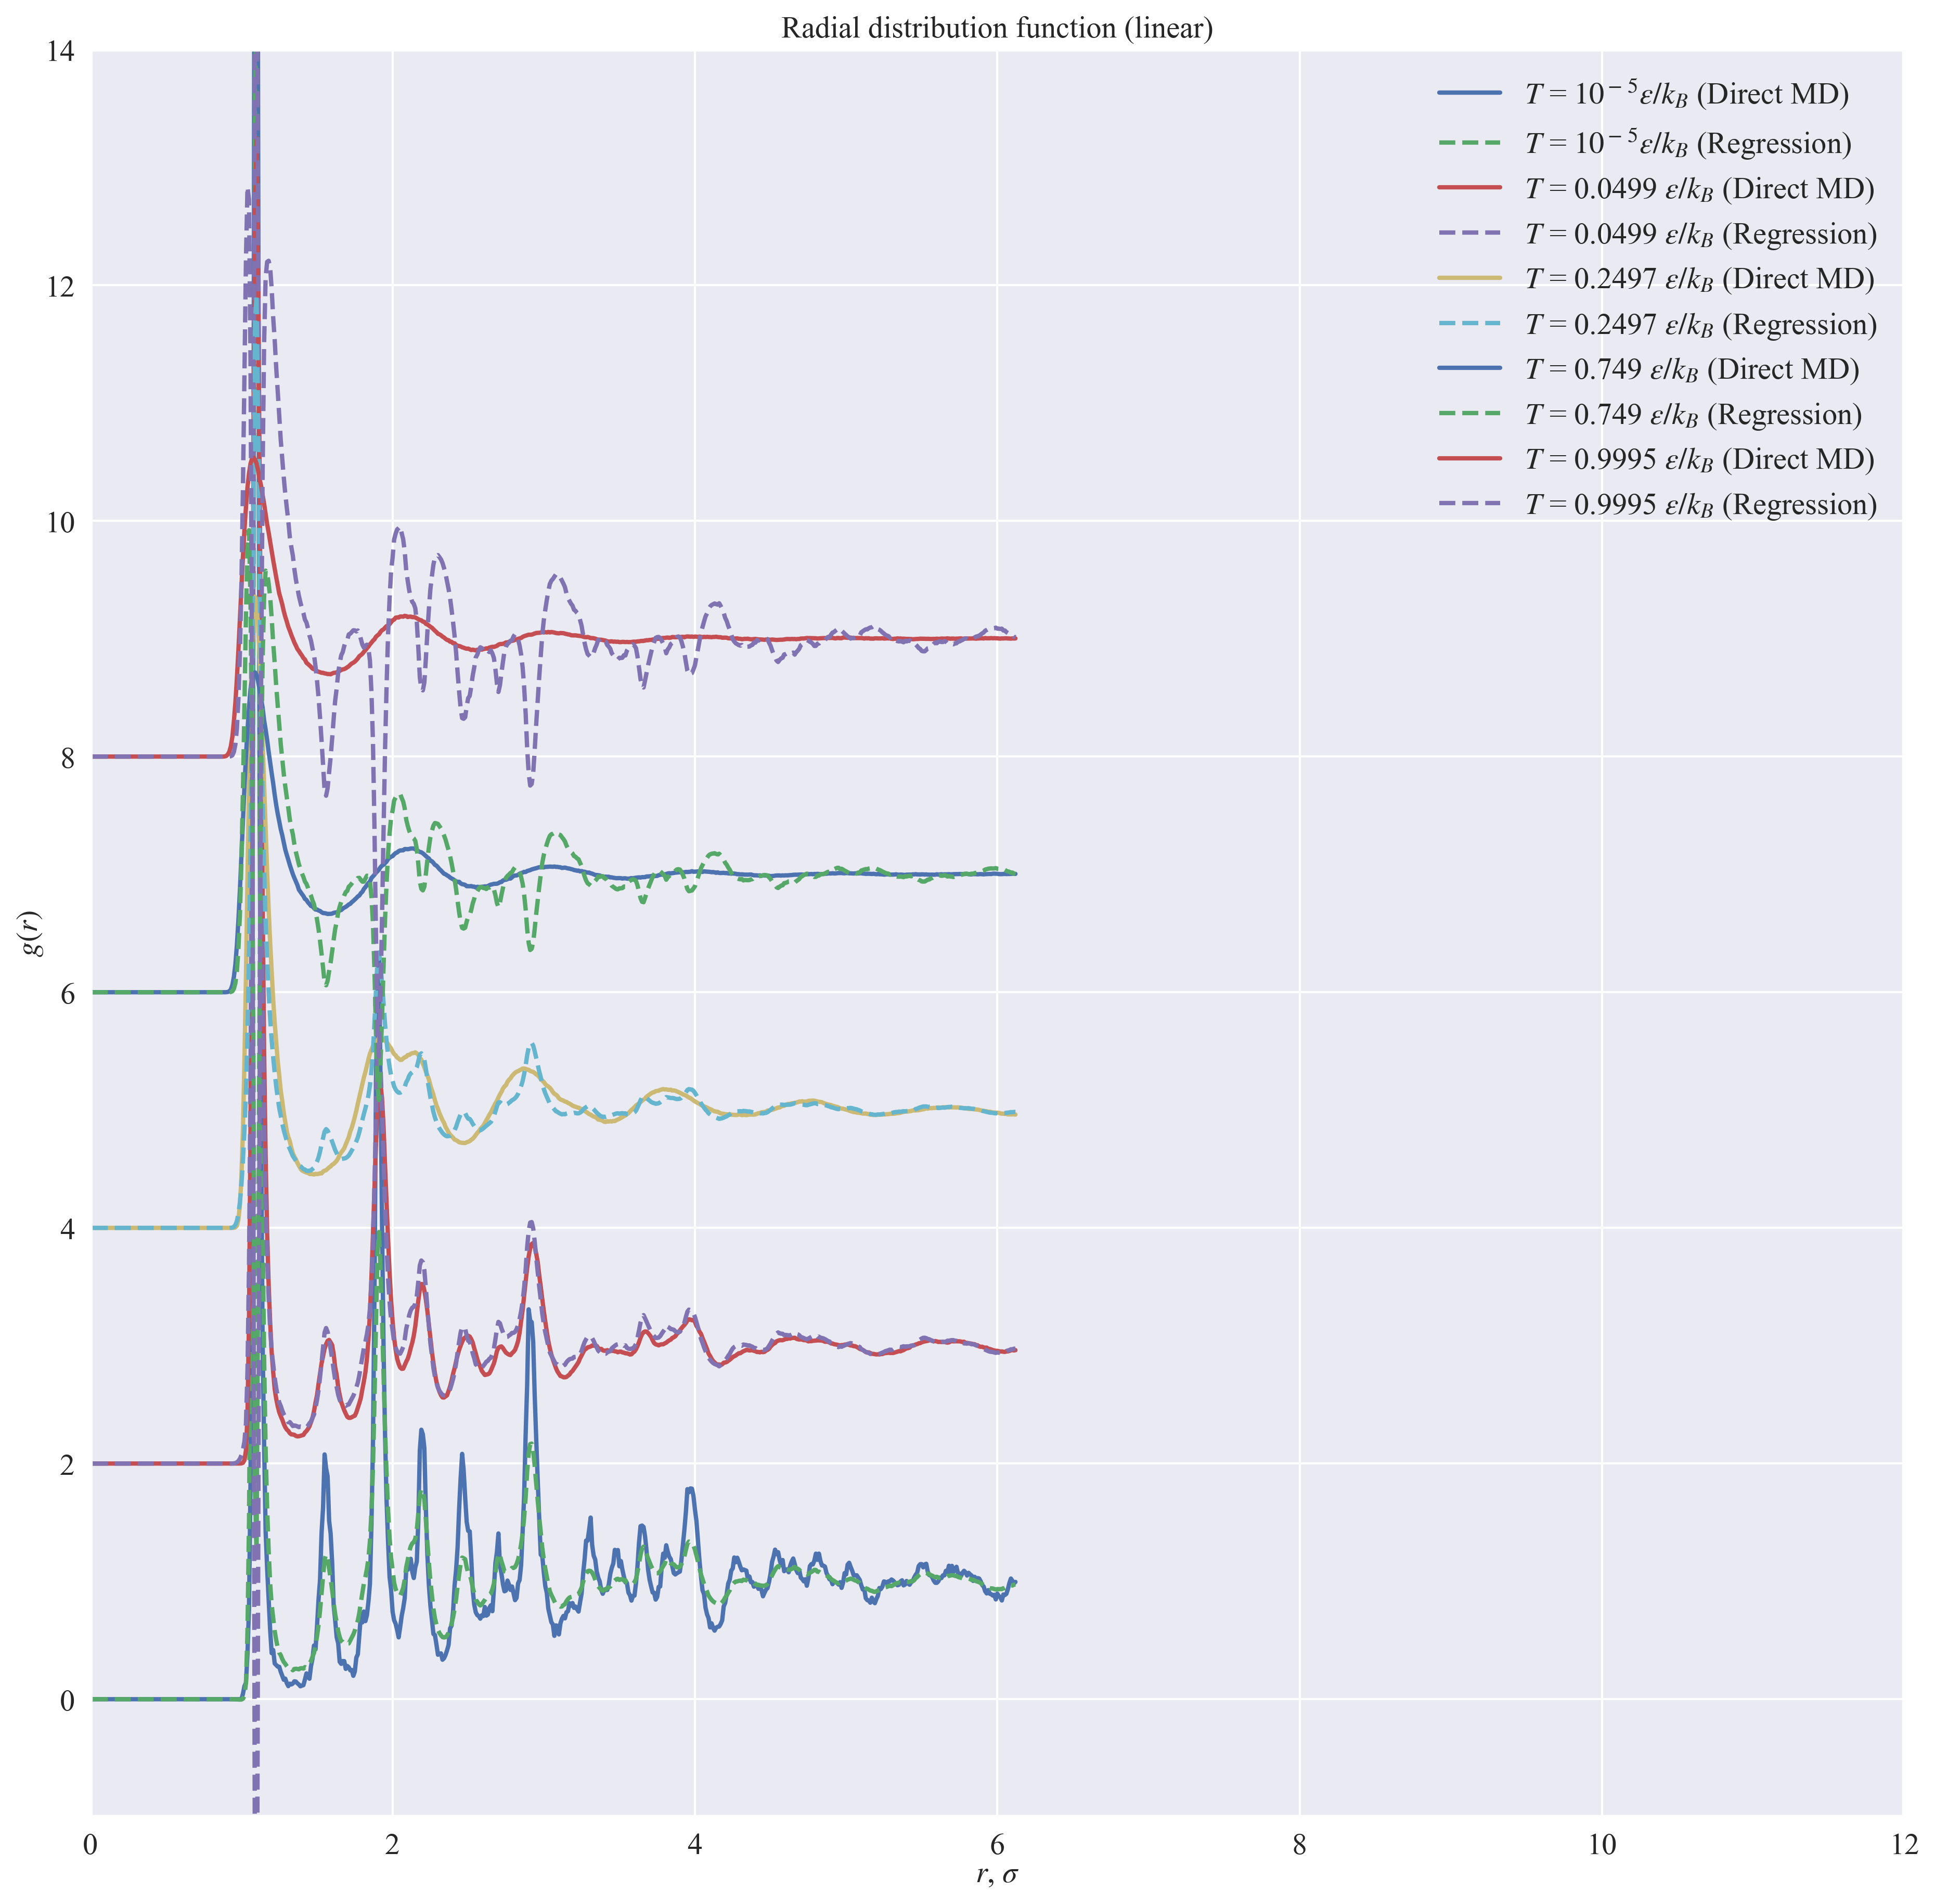

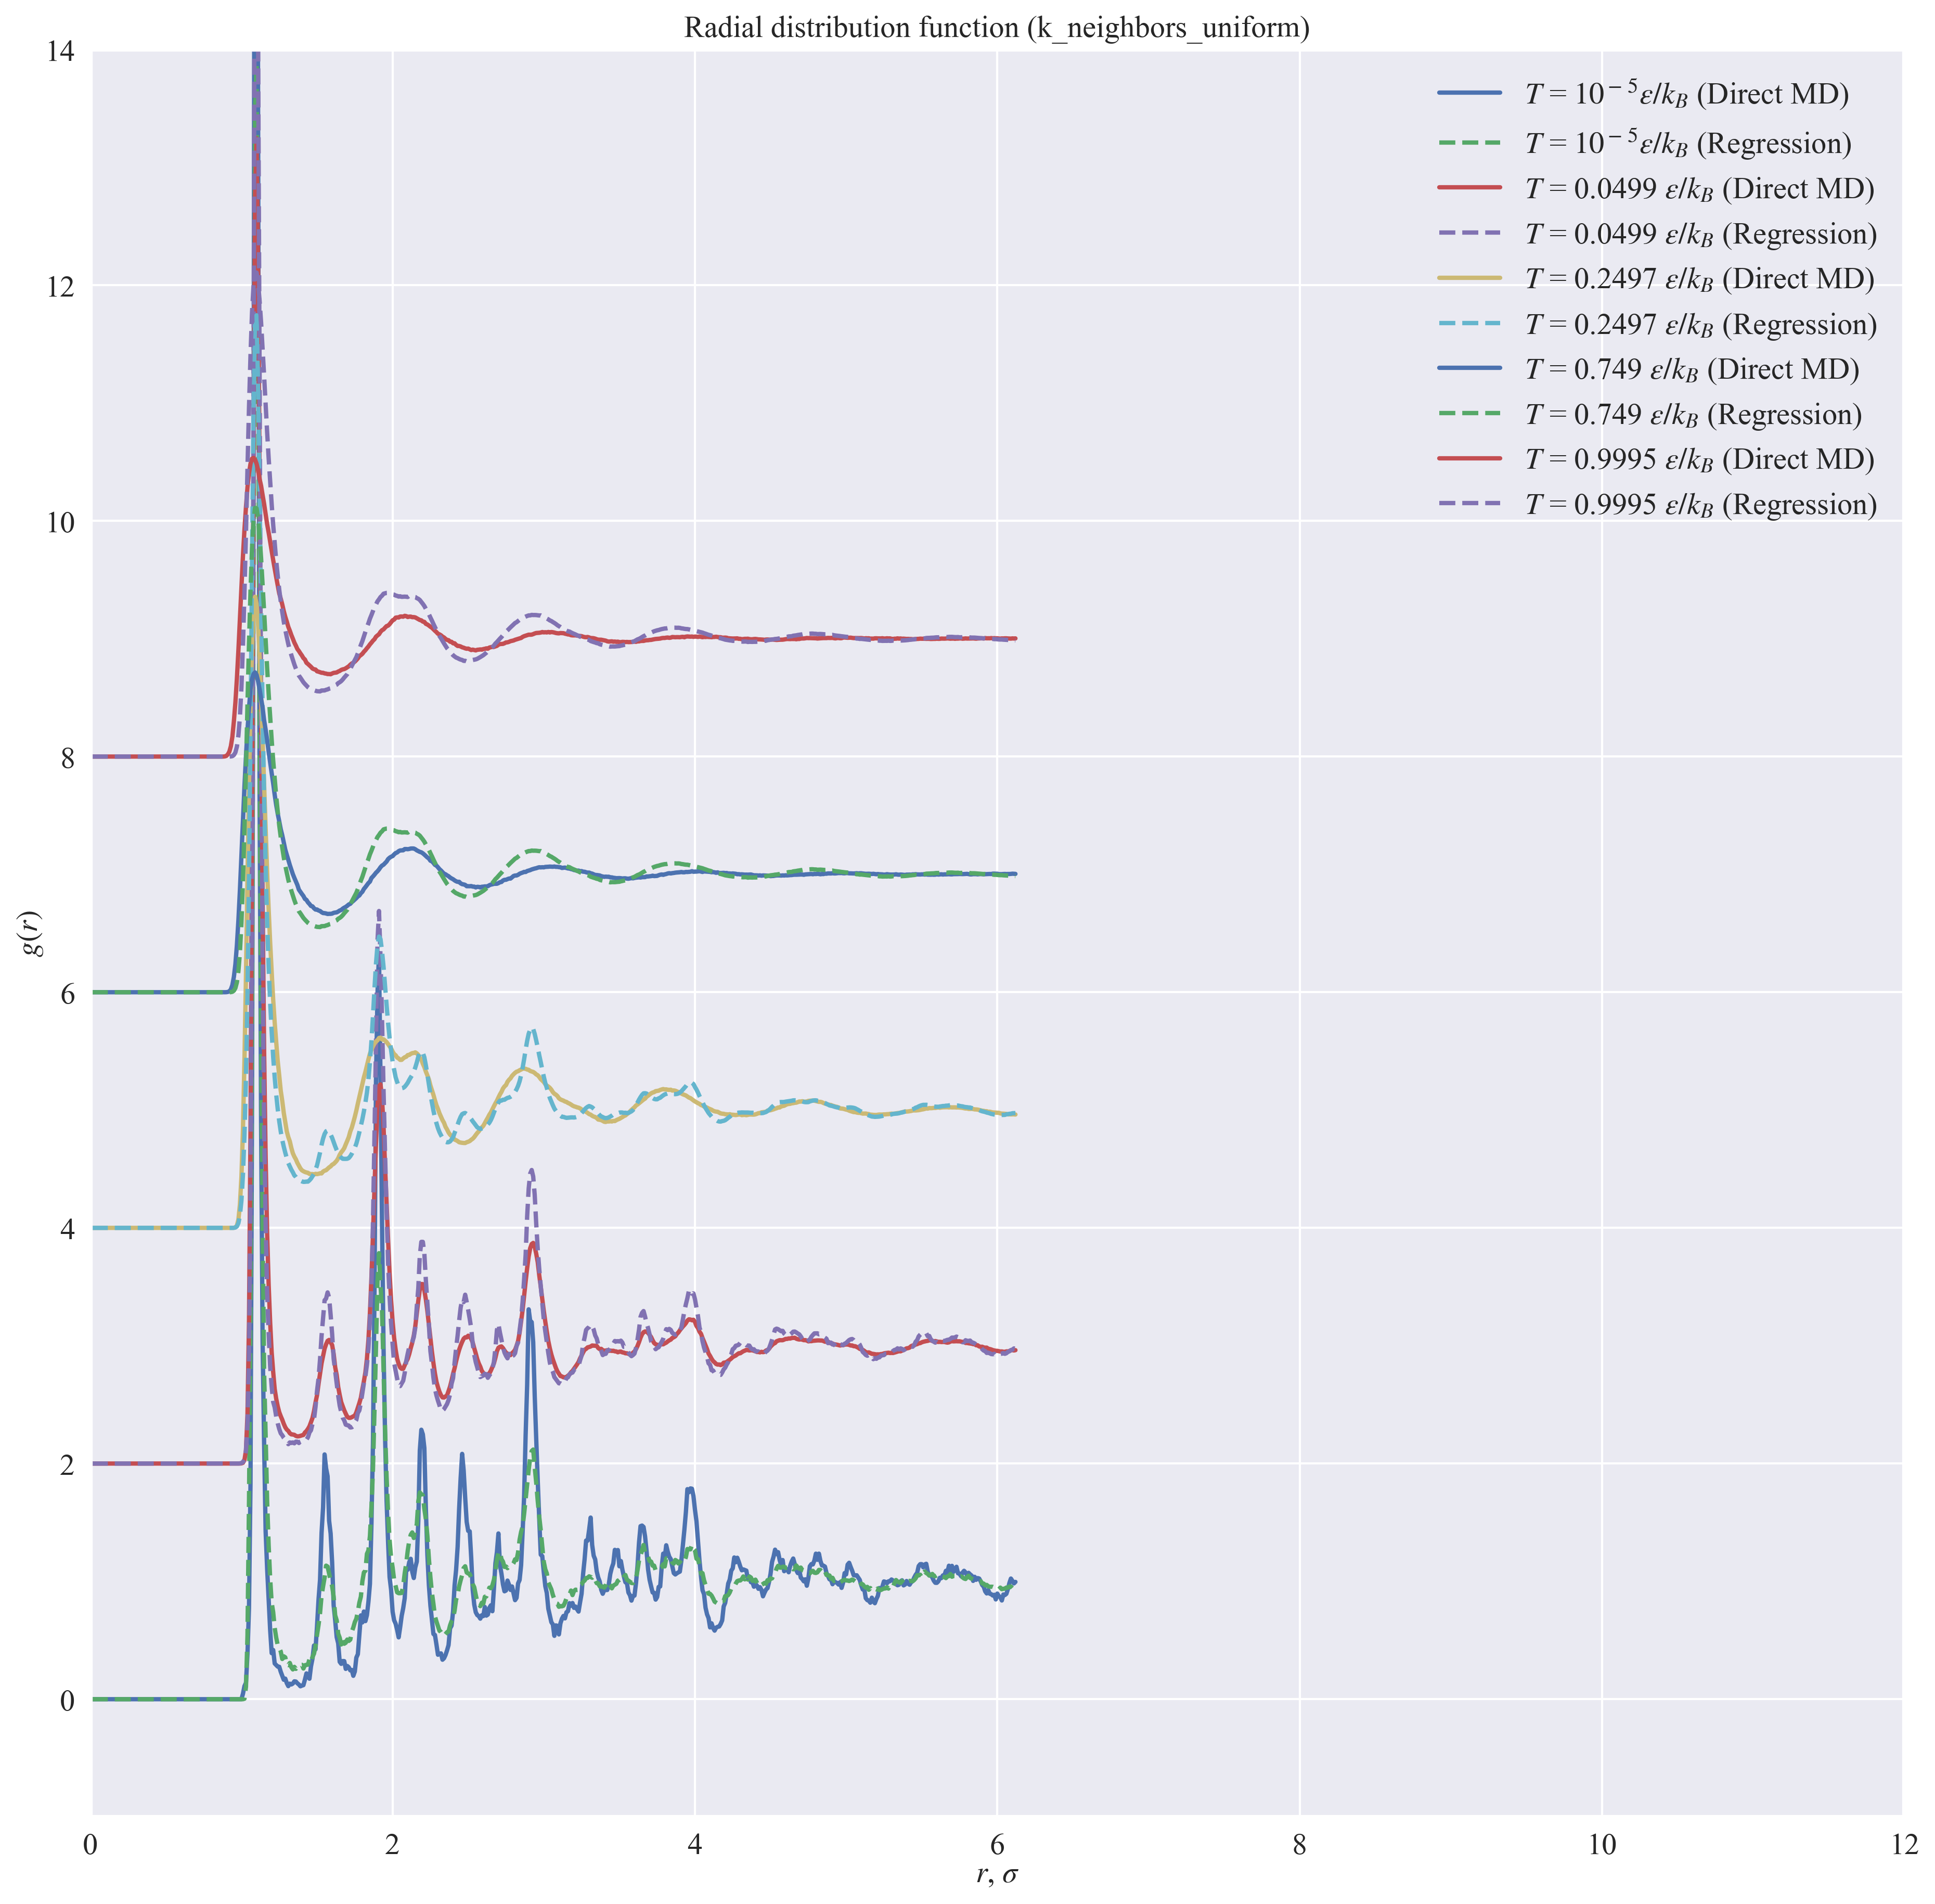

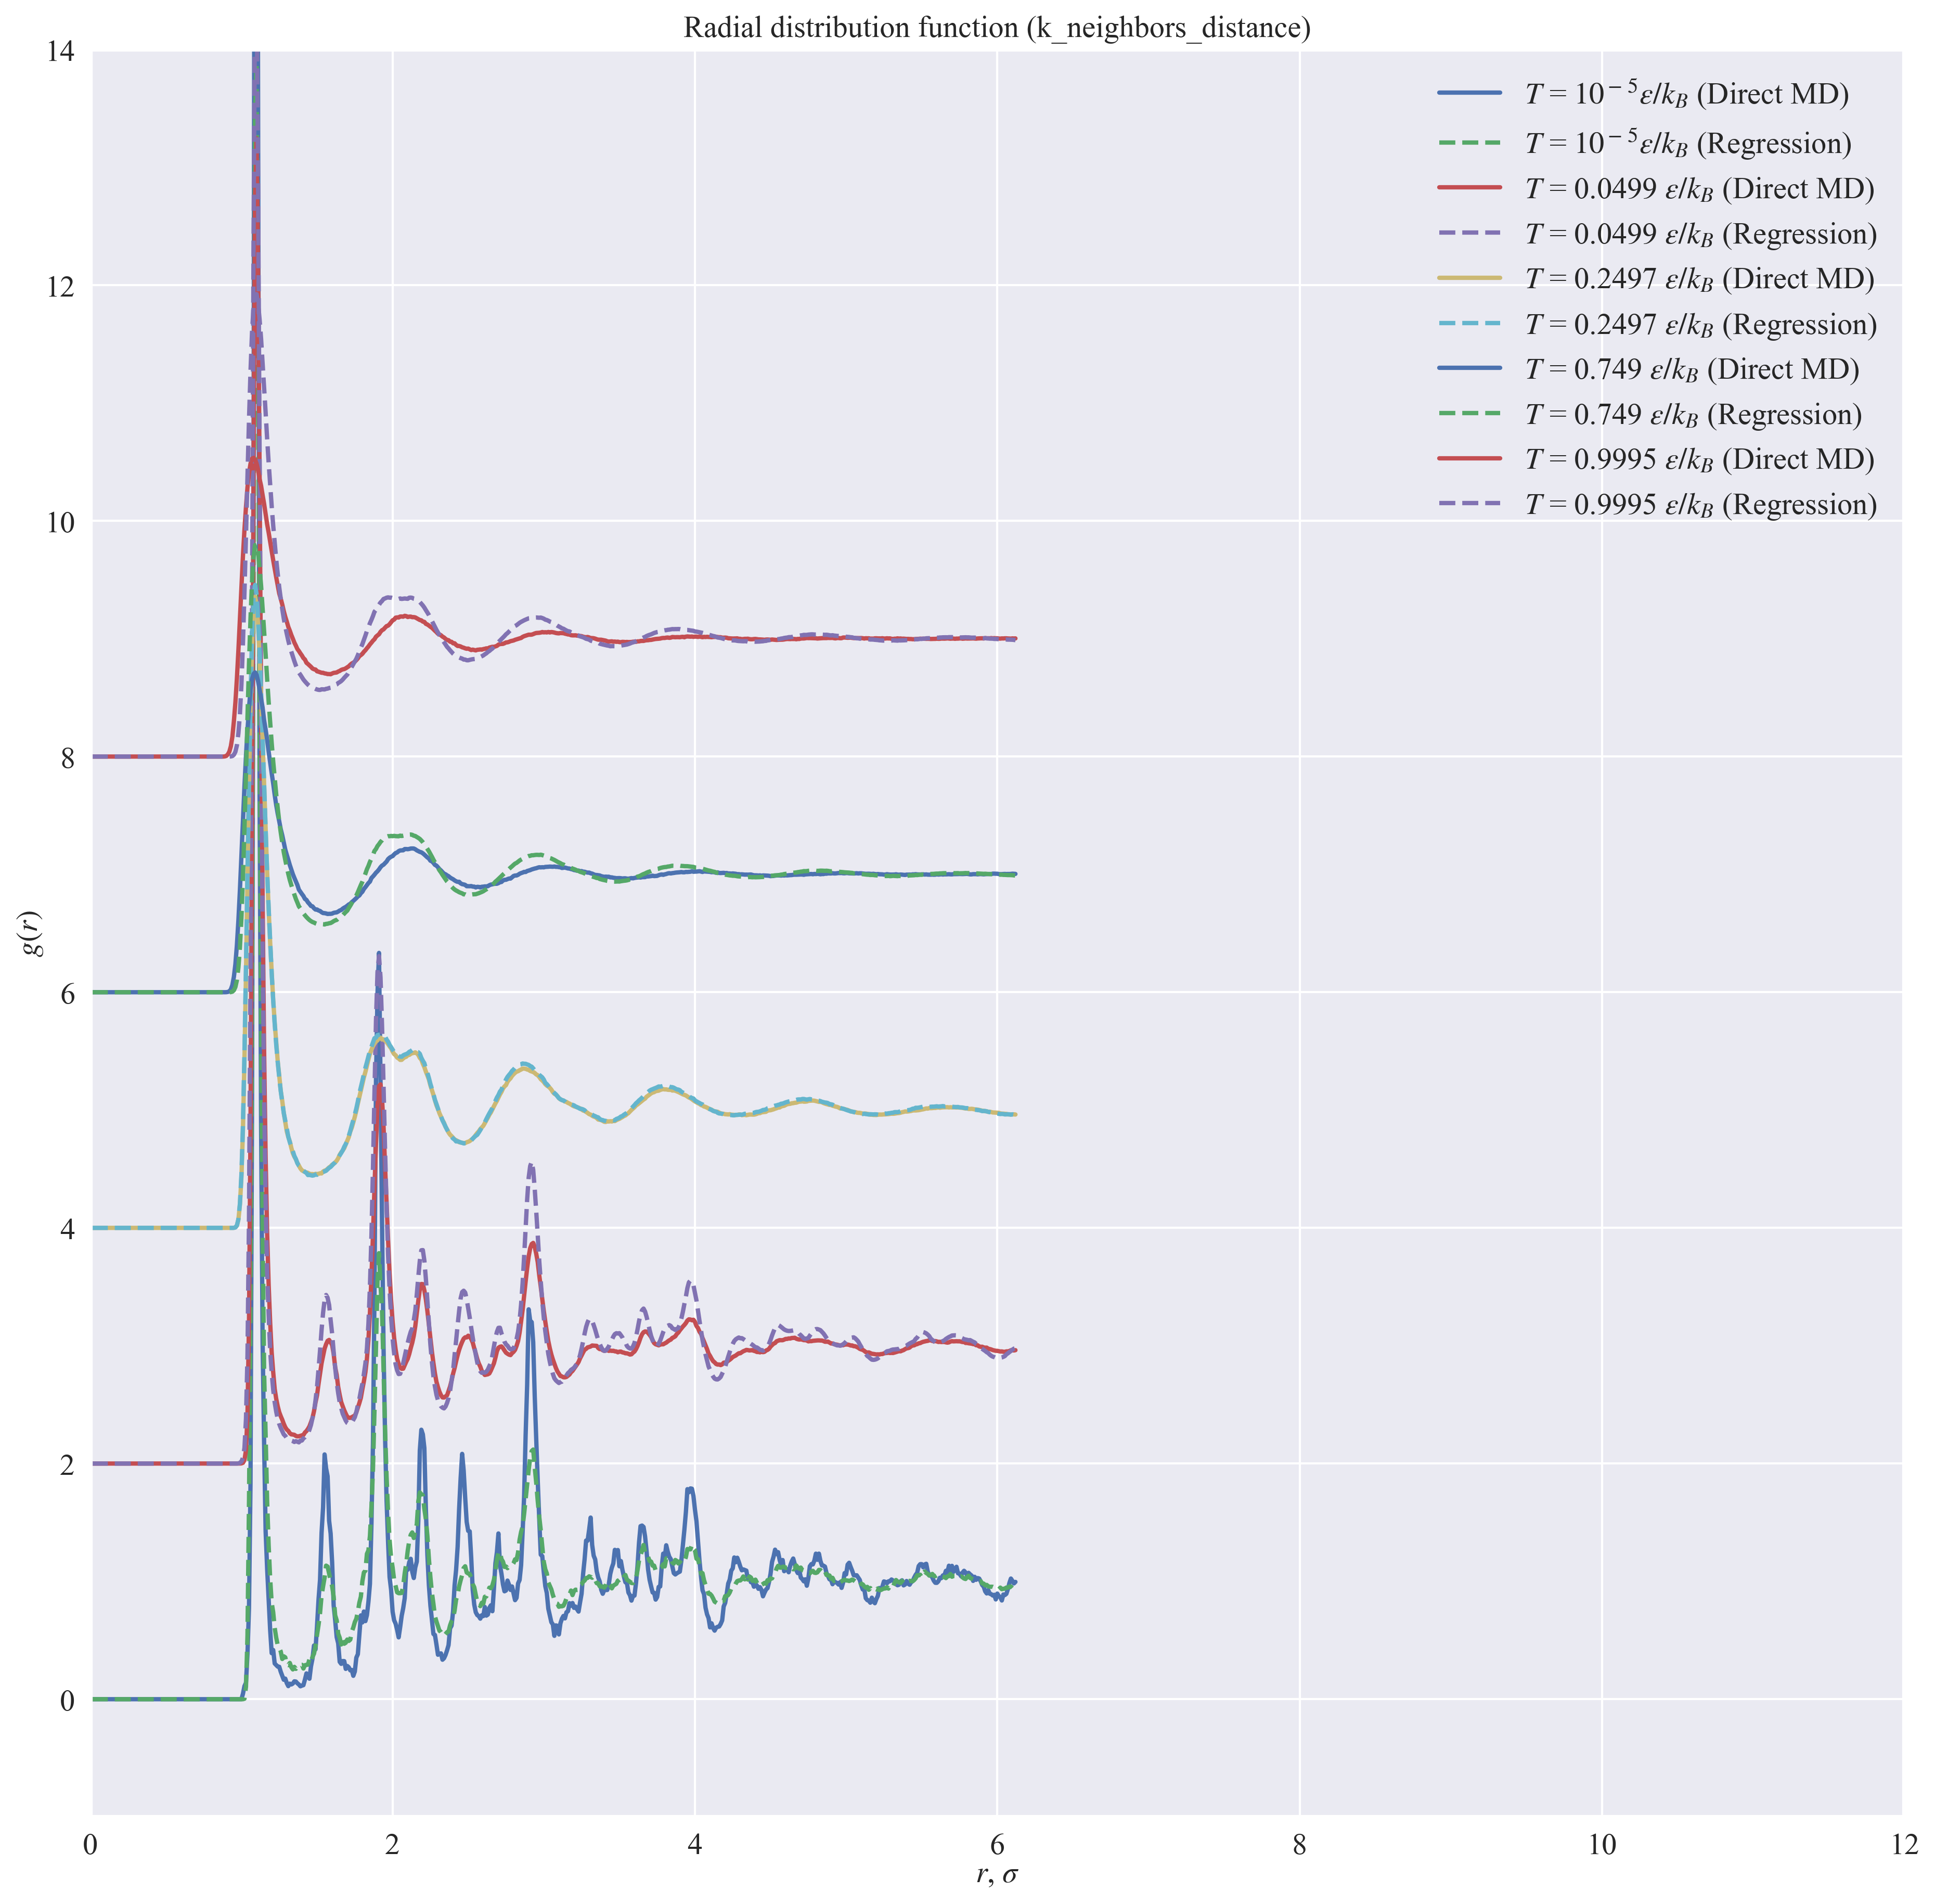

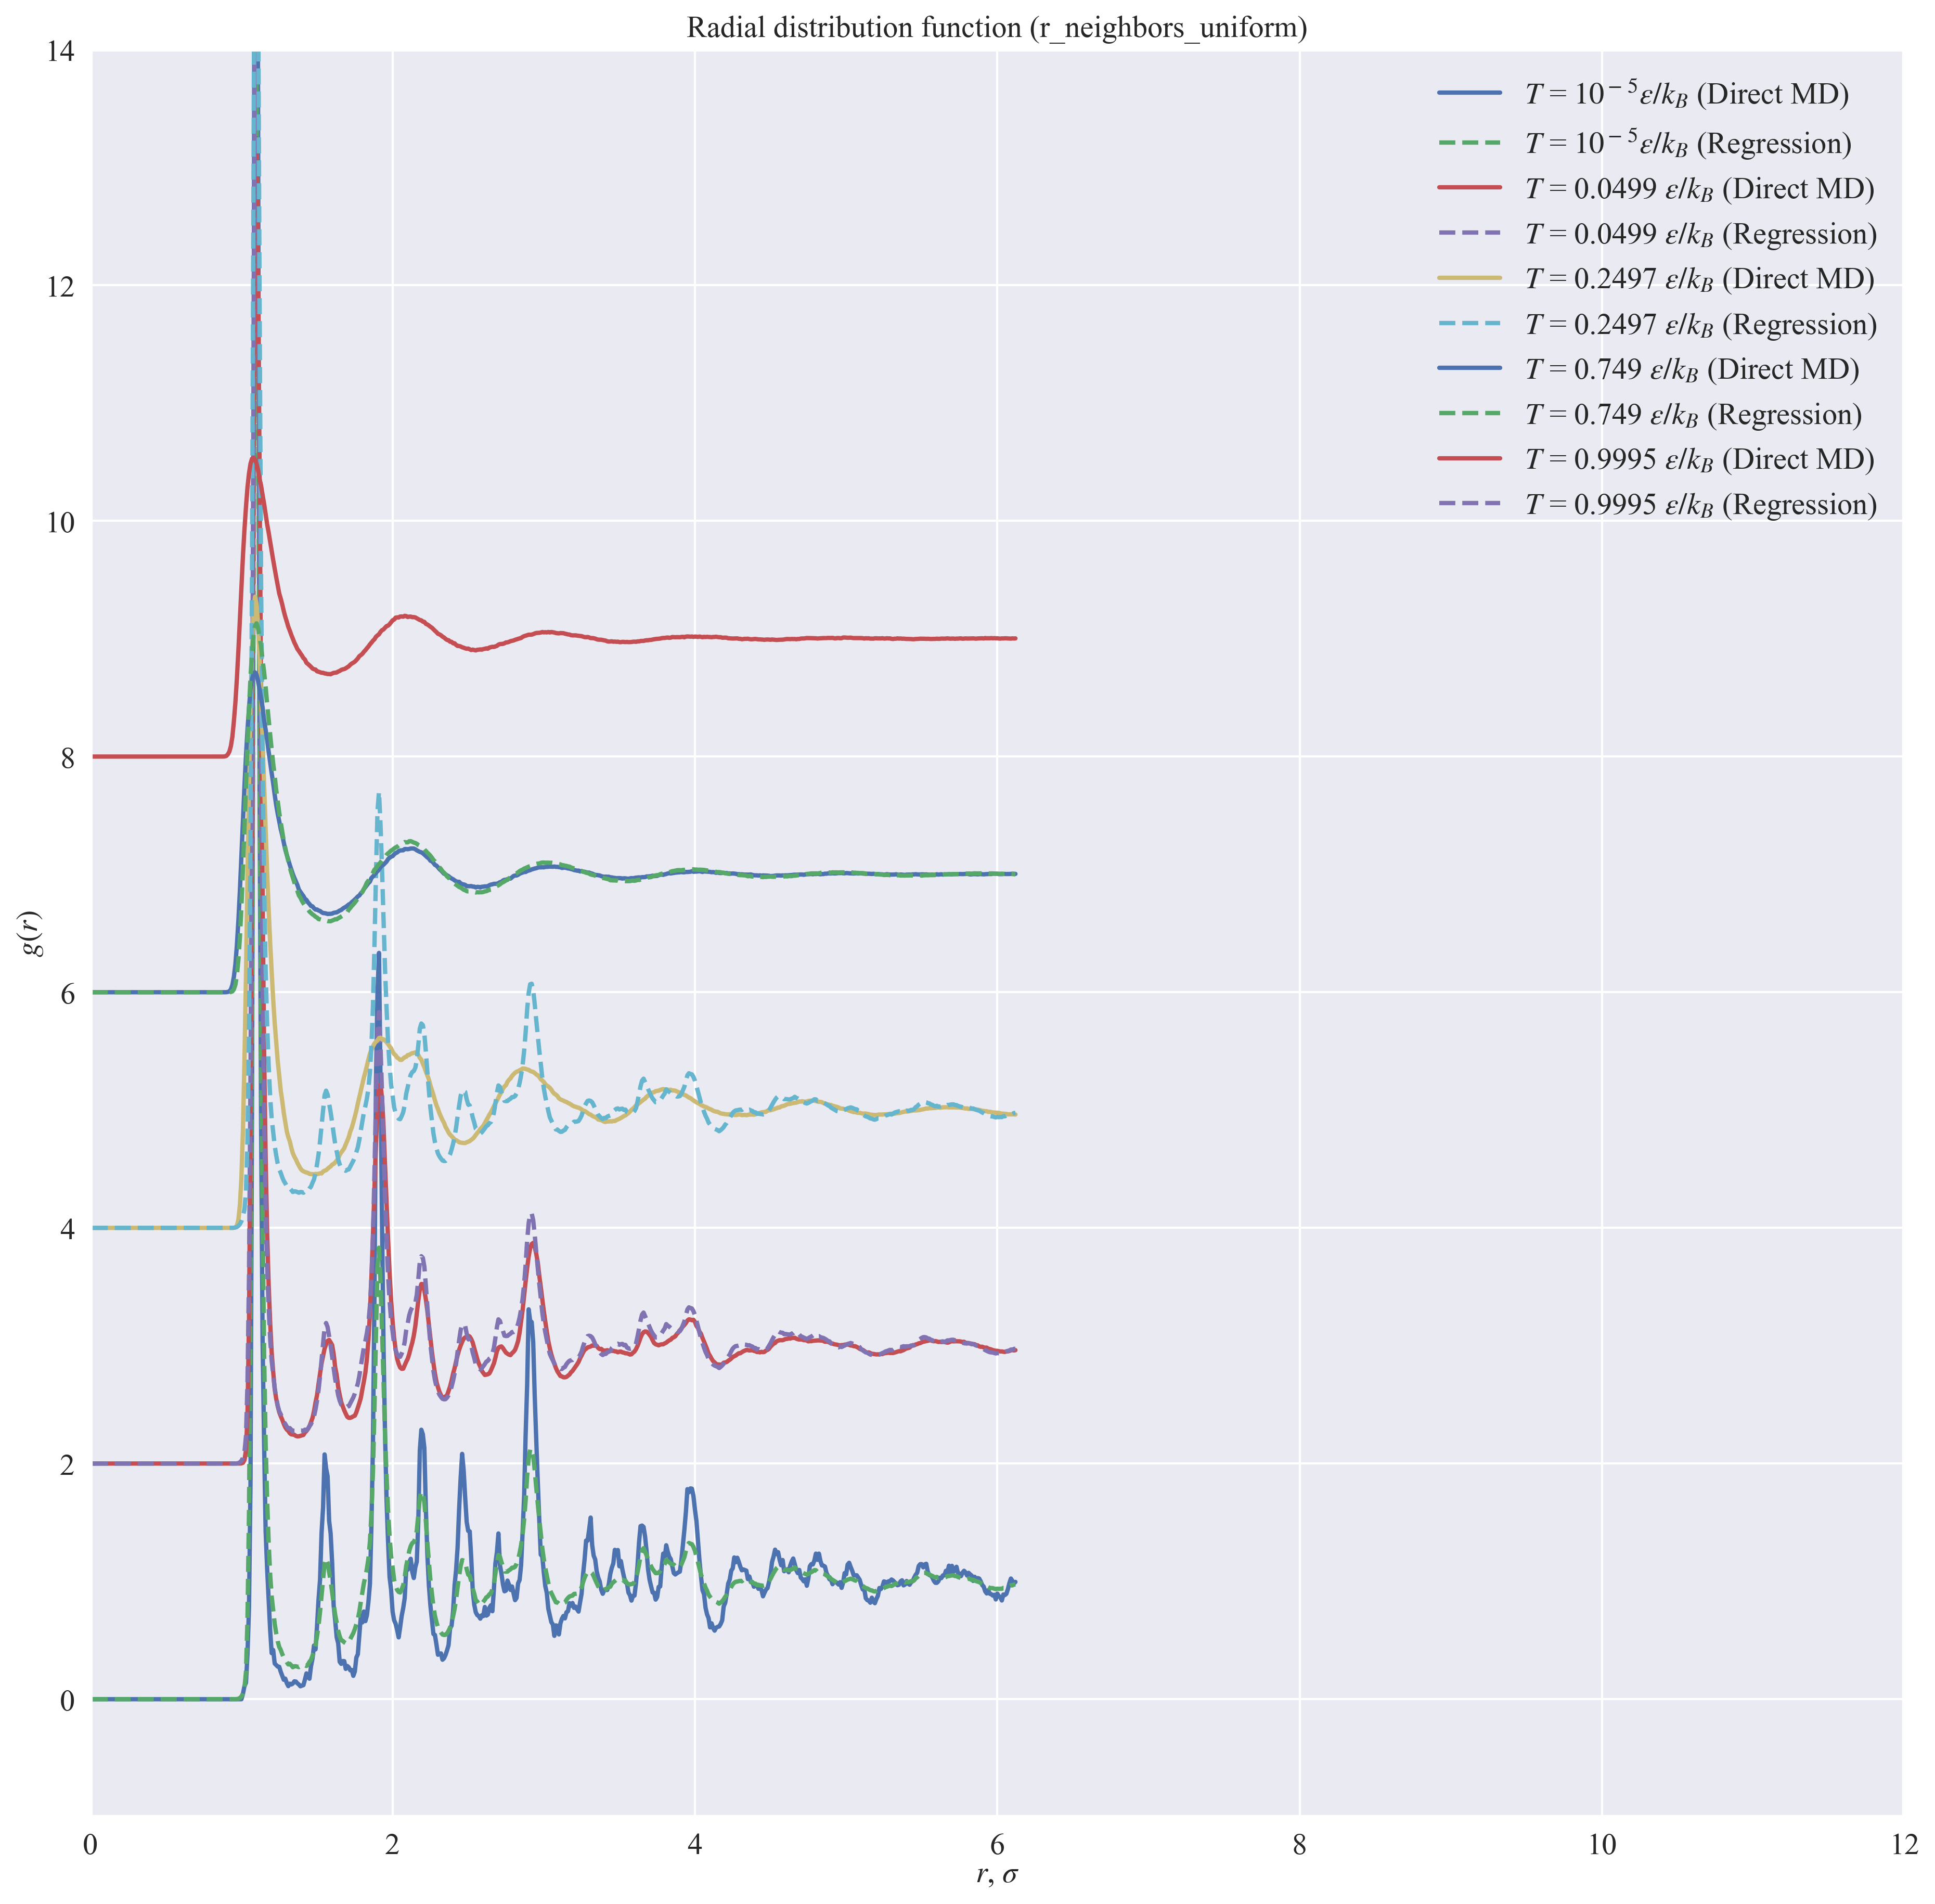

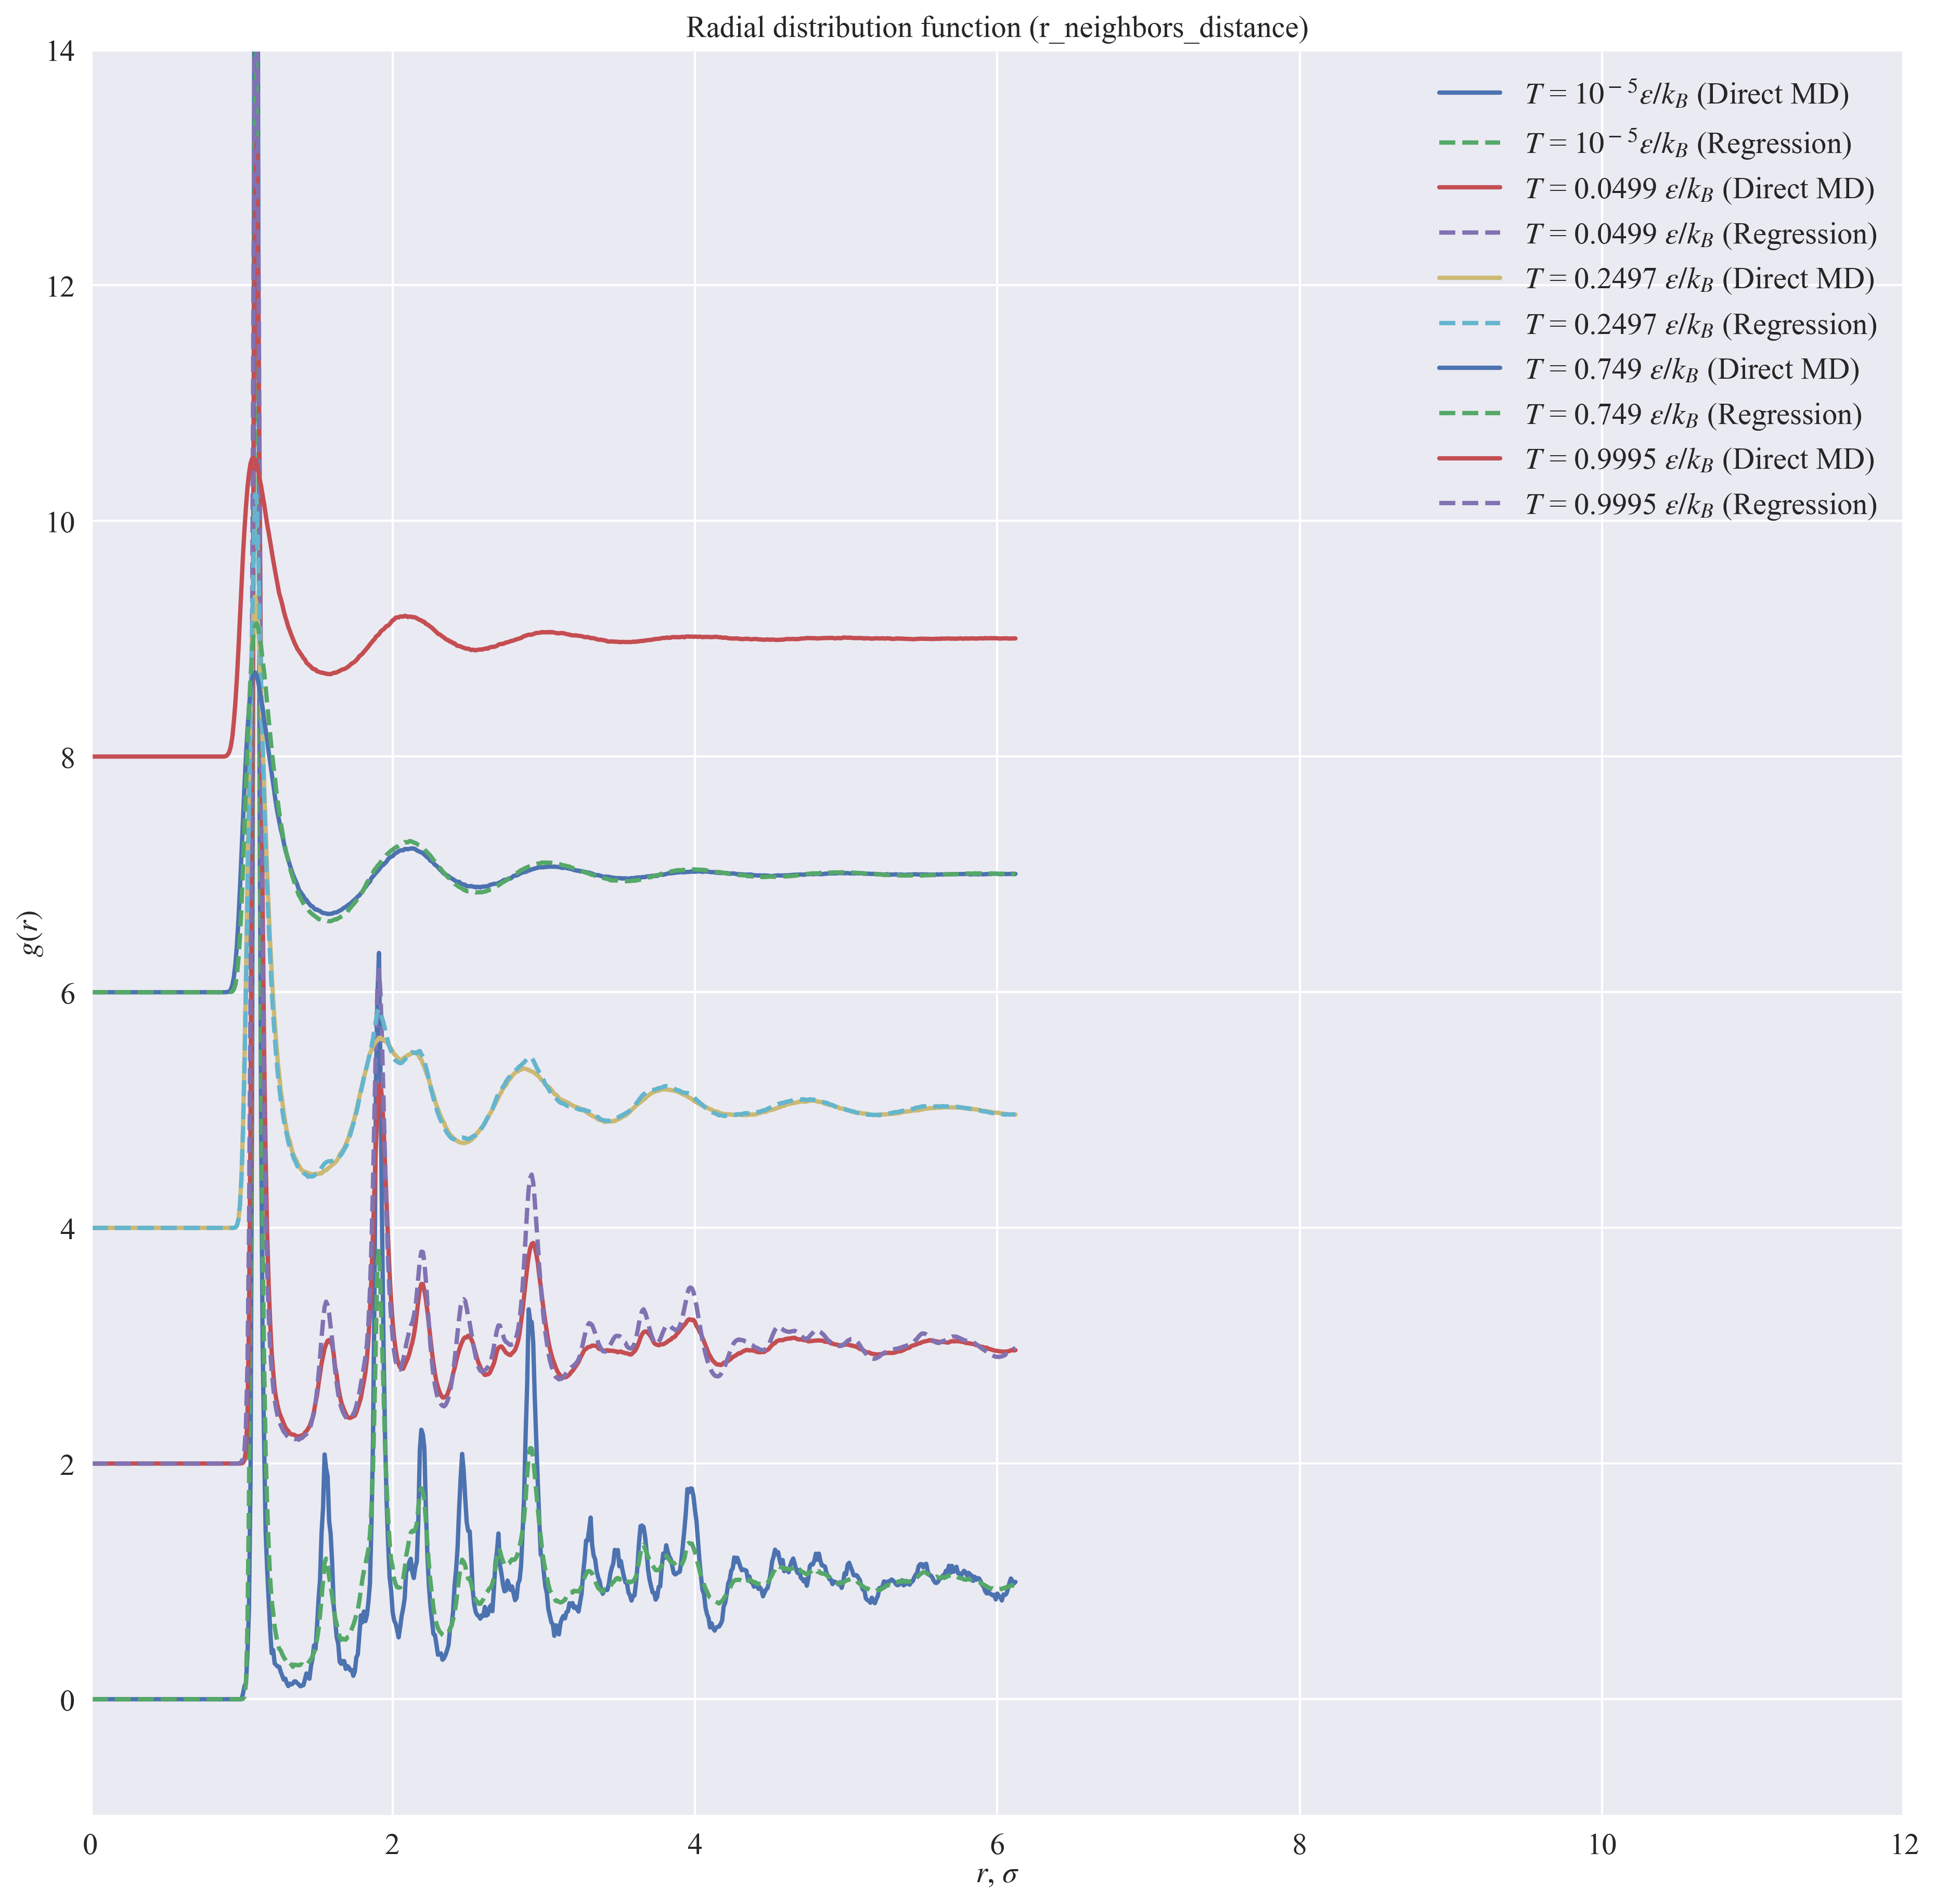

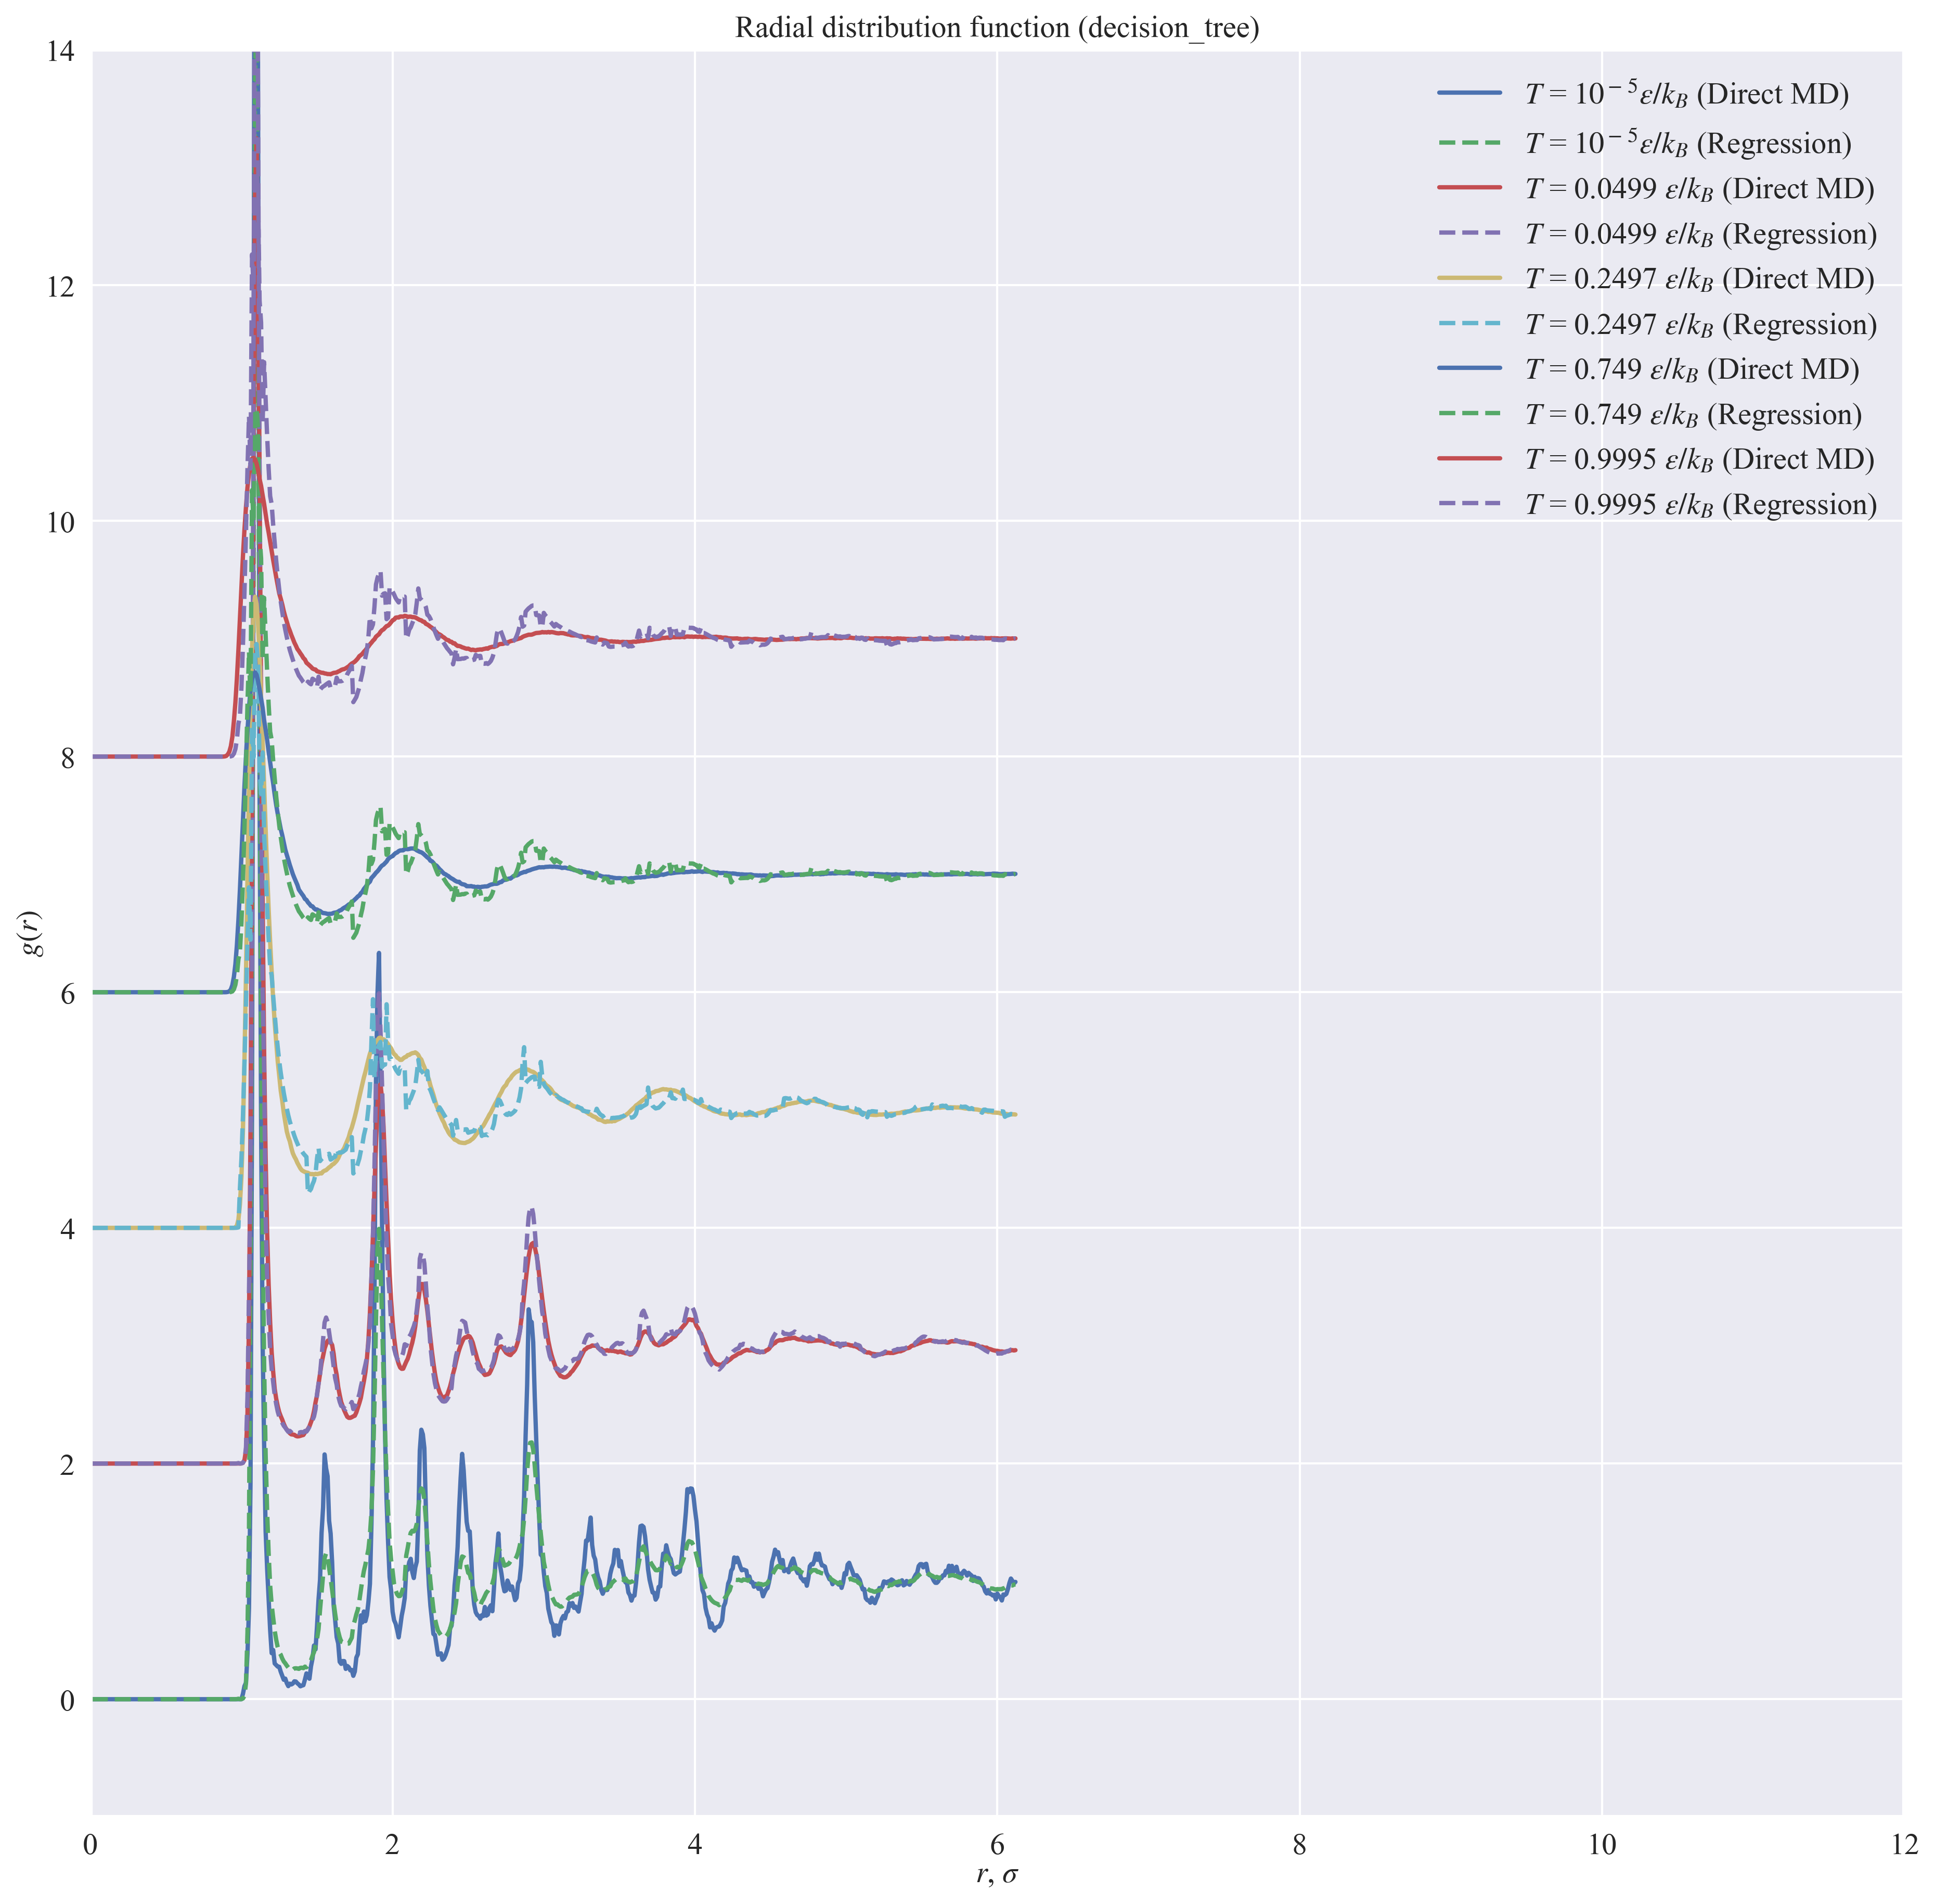

In [23]:
for key, value in predicted_rdf_points.items():
    plotter = Plotter(
        path_to_plots=PATH_TO_CURRENT_PLOTS,
        limits=dict(
            left=0,
            right=12,
            bottom=-1,
            top=14,
        ),
        size=(15, 15),
        labels=('radius', 'rdf'),
    )
    plotter.ax.set_title(f'Radial distribution function ({key})')
    shown_temperatures = []
    for i, setup in enumerate(setups_slow):
        temperature = setup["temperature"]
        if temperature not in predicted_temperatures:
            continue
        if round(temperature, 4) in shown_temperatures:
            continue
        else:
            shift_scale = 2
            plotter.ax.plot(
                rdf_slow.data['radius'],
                rdf_slow.data[f'setup_{i}'] + shift_scale * len(shown_temperatures),
                label=get_temperature_legend(temperature, 4) + ' (Direct MD)',
            )
            plotter.ax.plot(
                rdf_table.columns.values,
                value[temperature] + shift_scale * len(shown_temperatures),
                '--',
                label=get_temperature_legend(temperature, 4) + ' (Regression)',
            )
            shown_temperatures.append(round(temperature, 4))

    plotter.ax.legend()
    plotter.save_plot(f'rdf_with_predicted_cooling_{key}.png')
    plt.show()

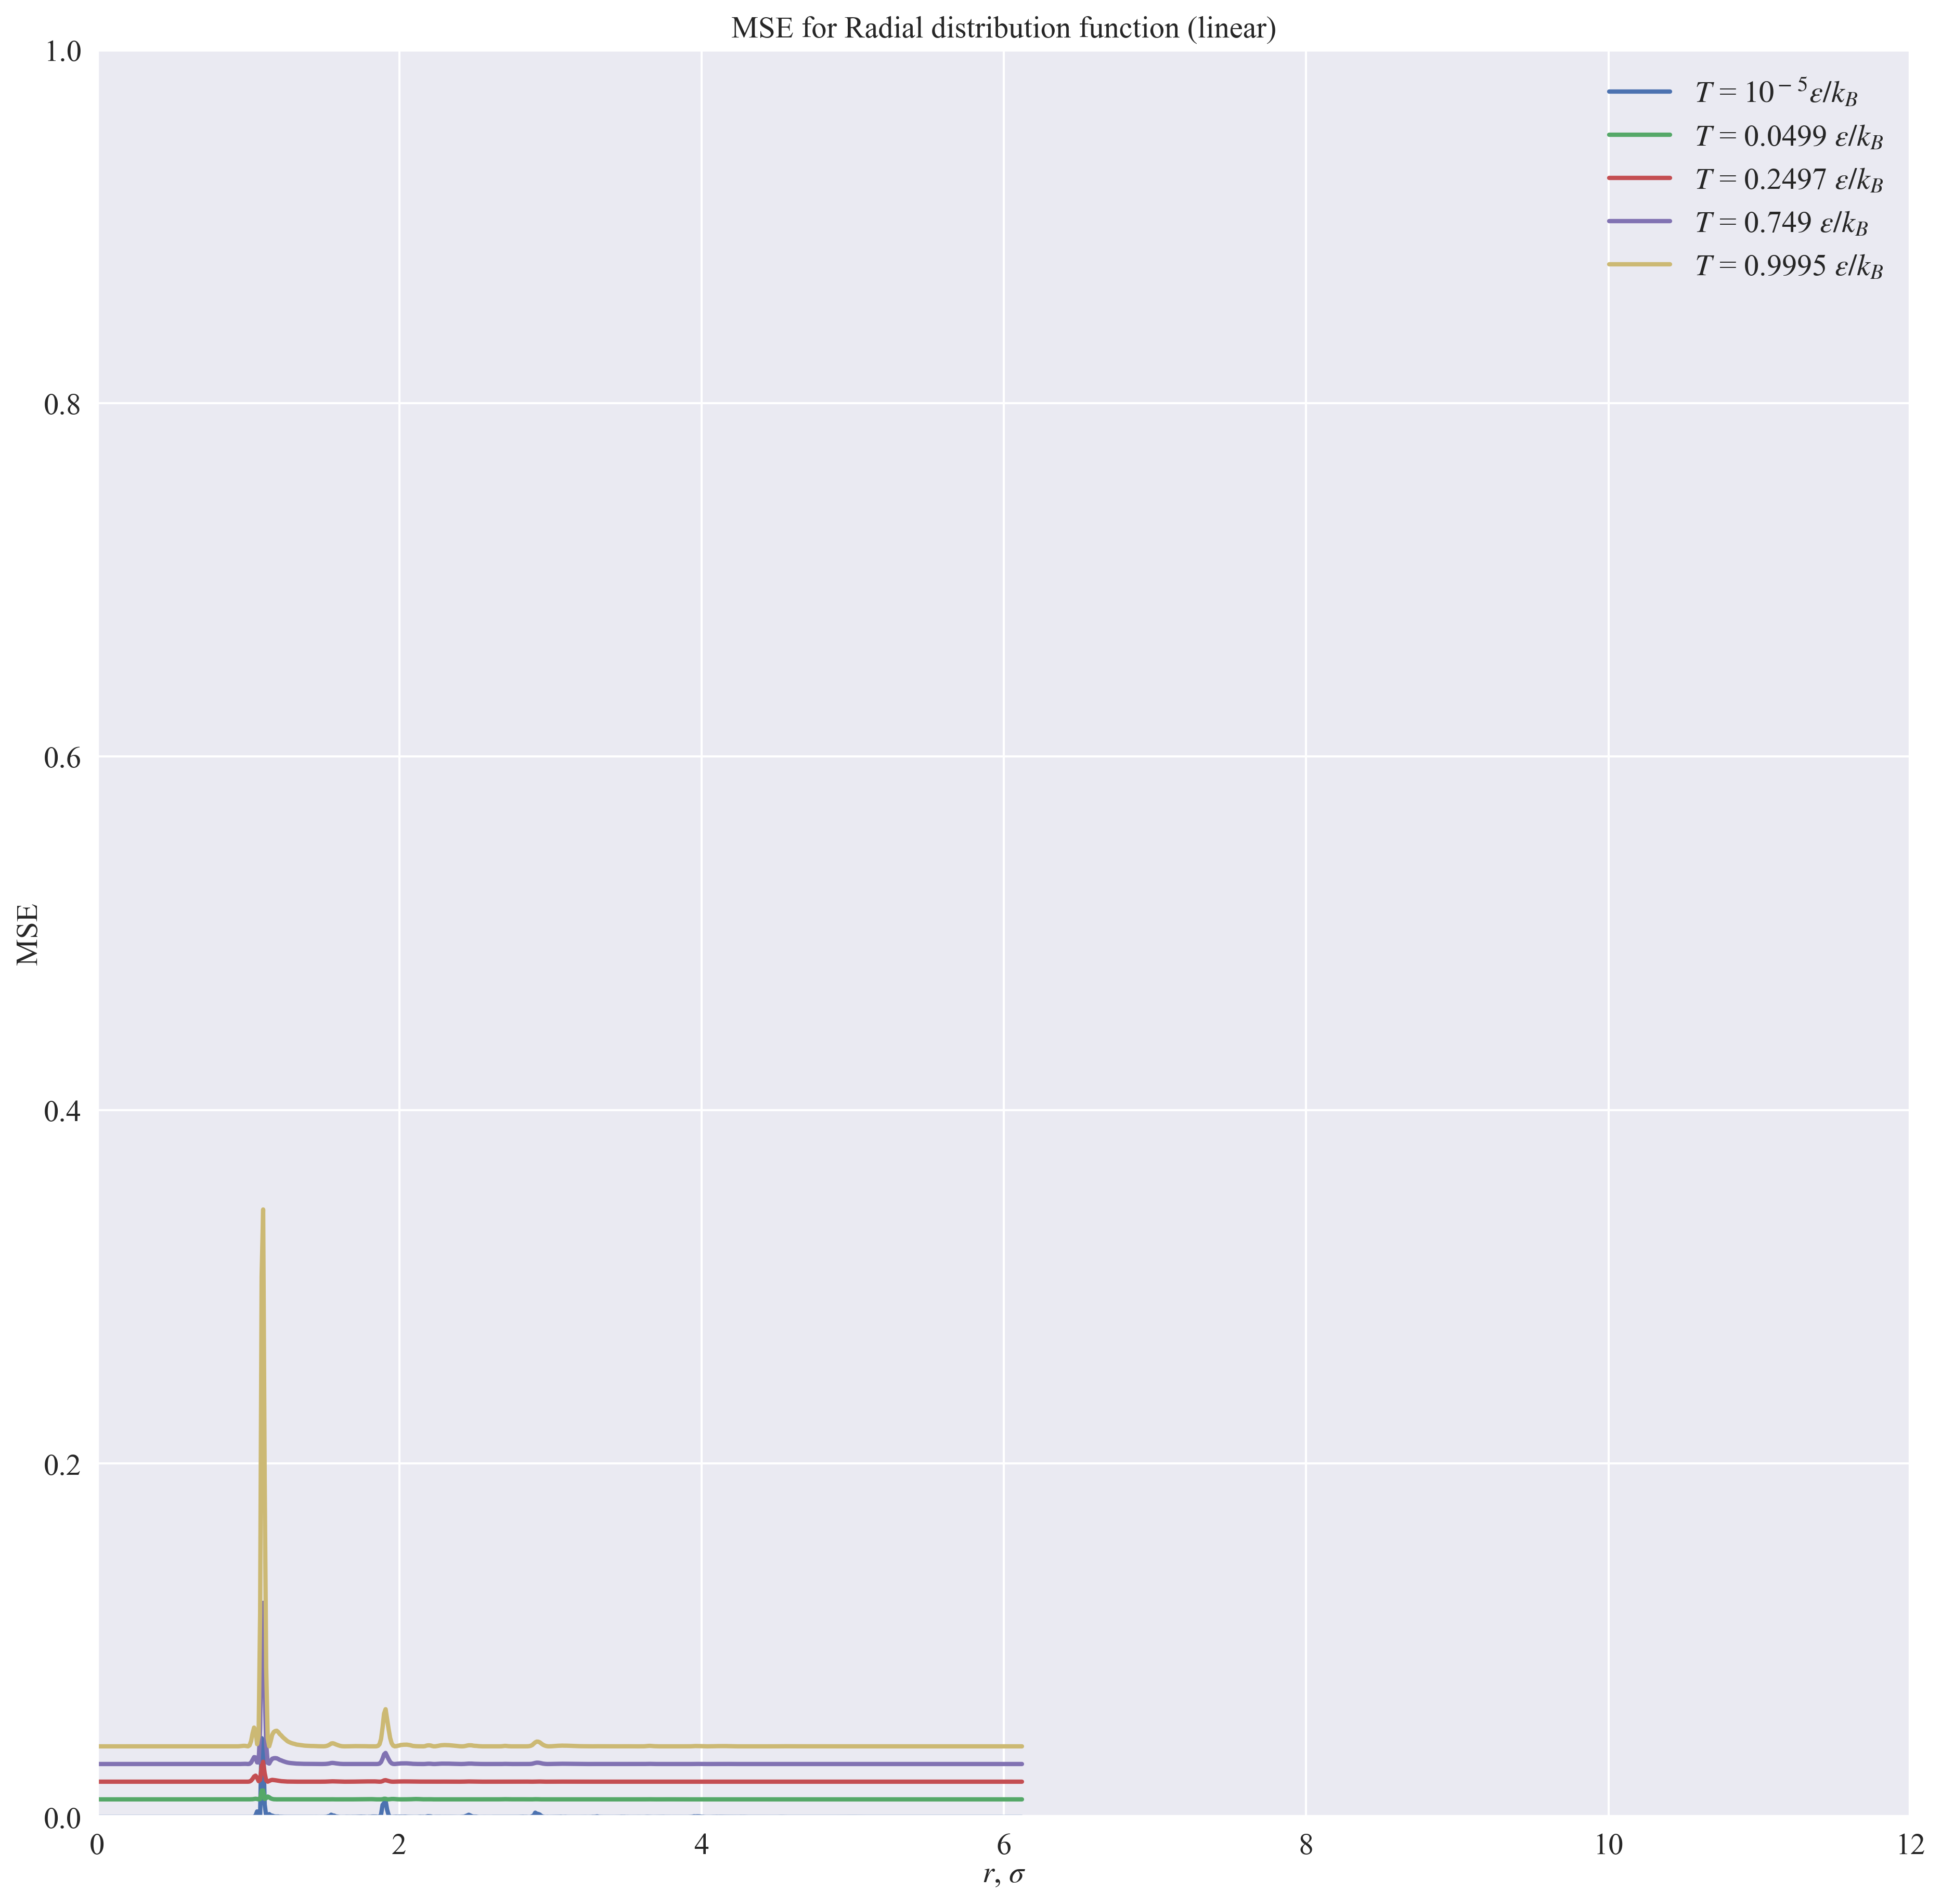

<Figure size 1771.65x1771.65 with 0 Axes>

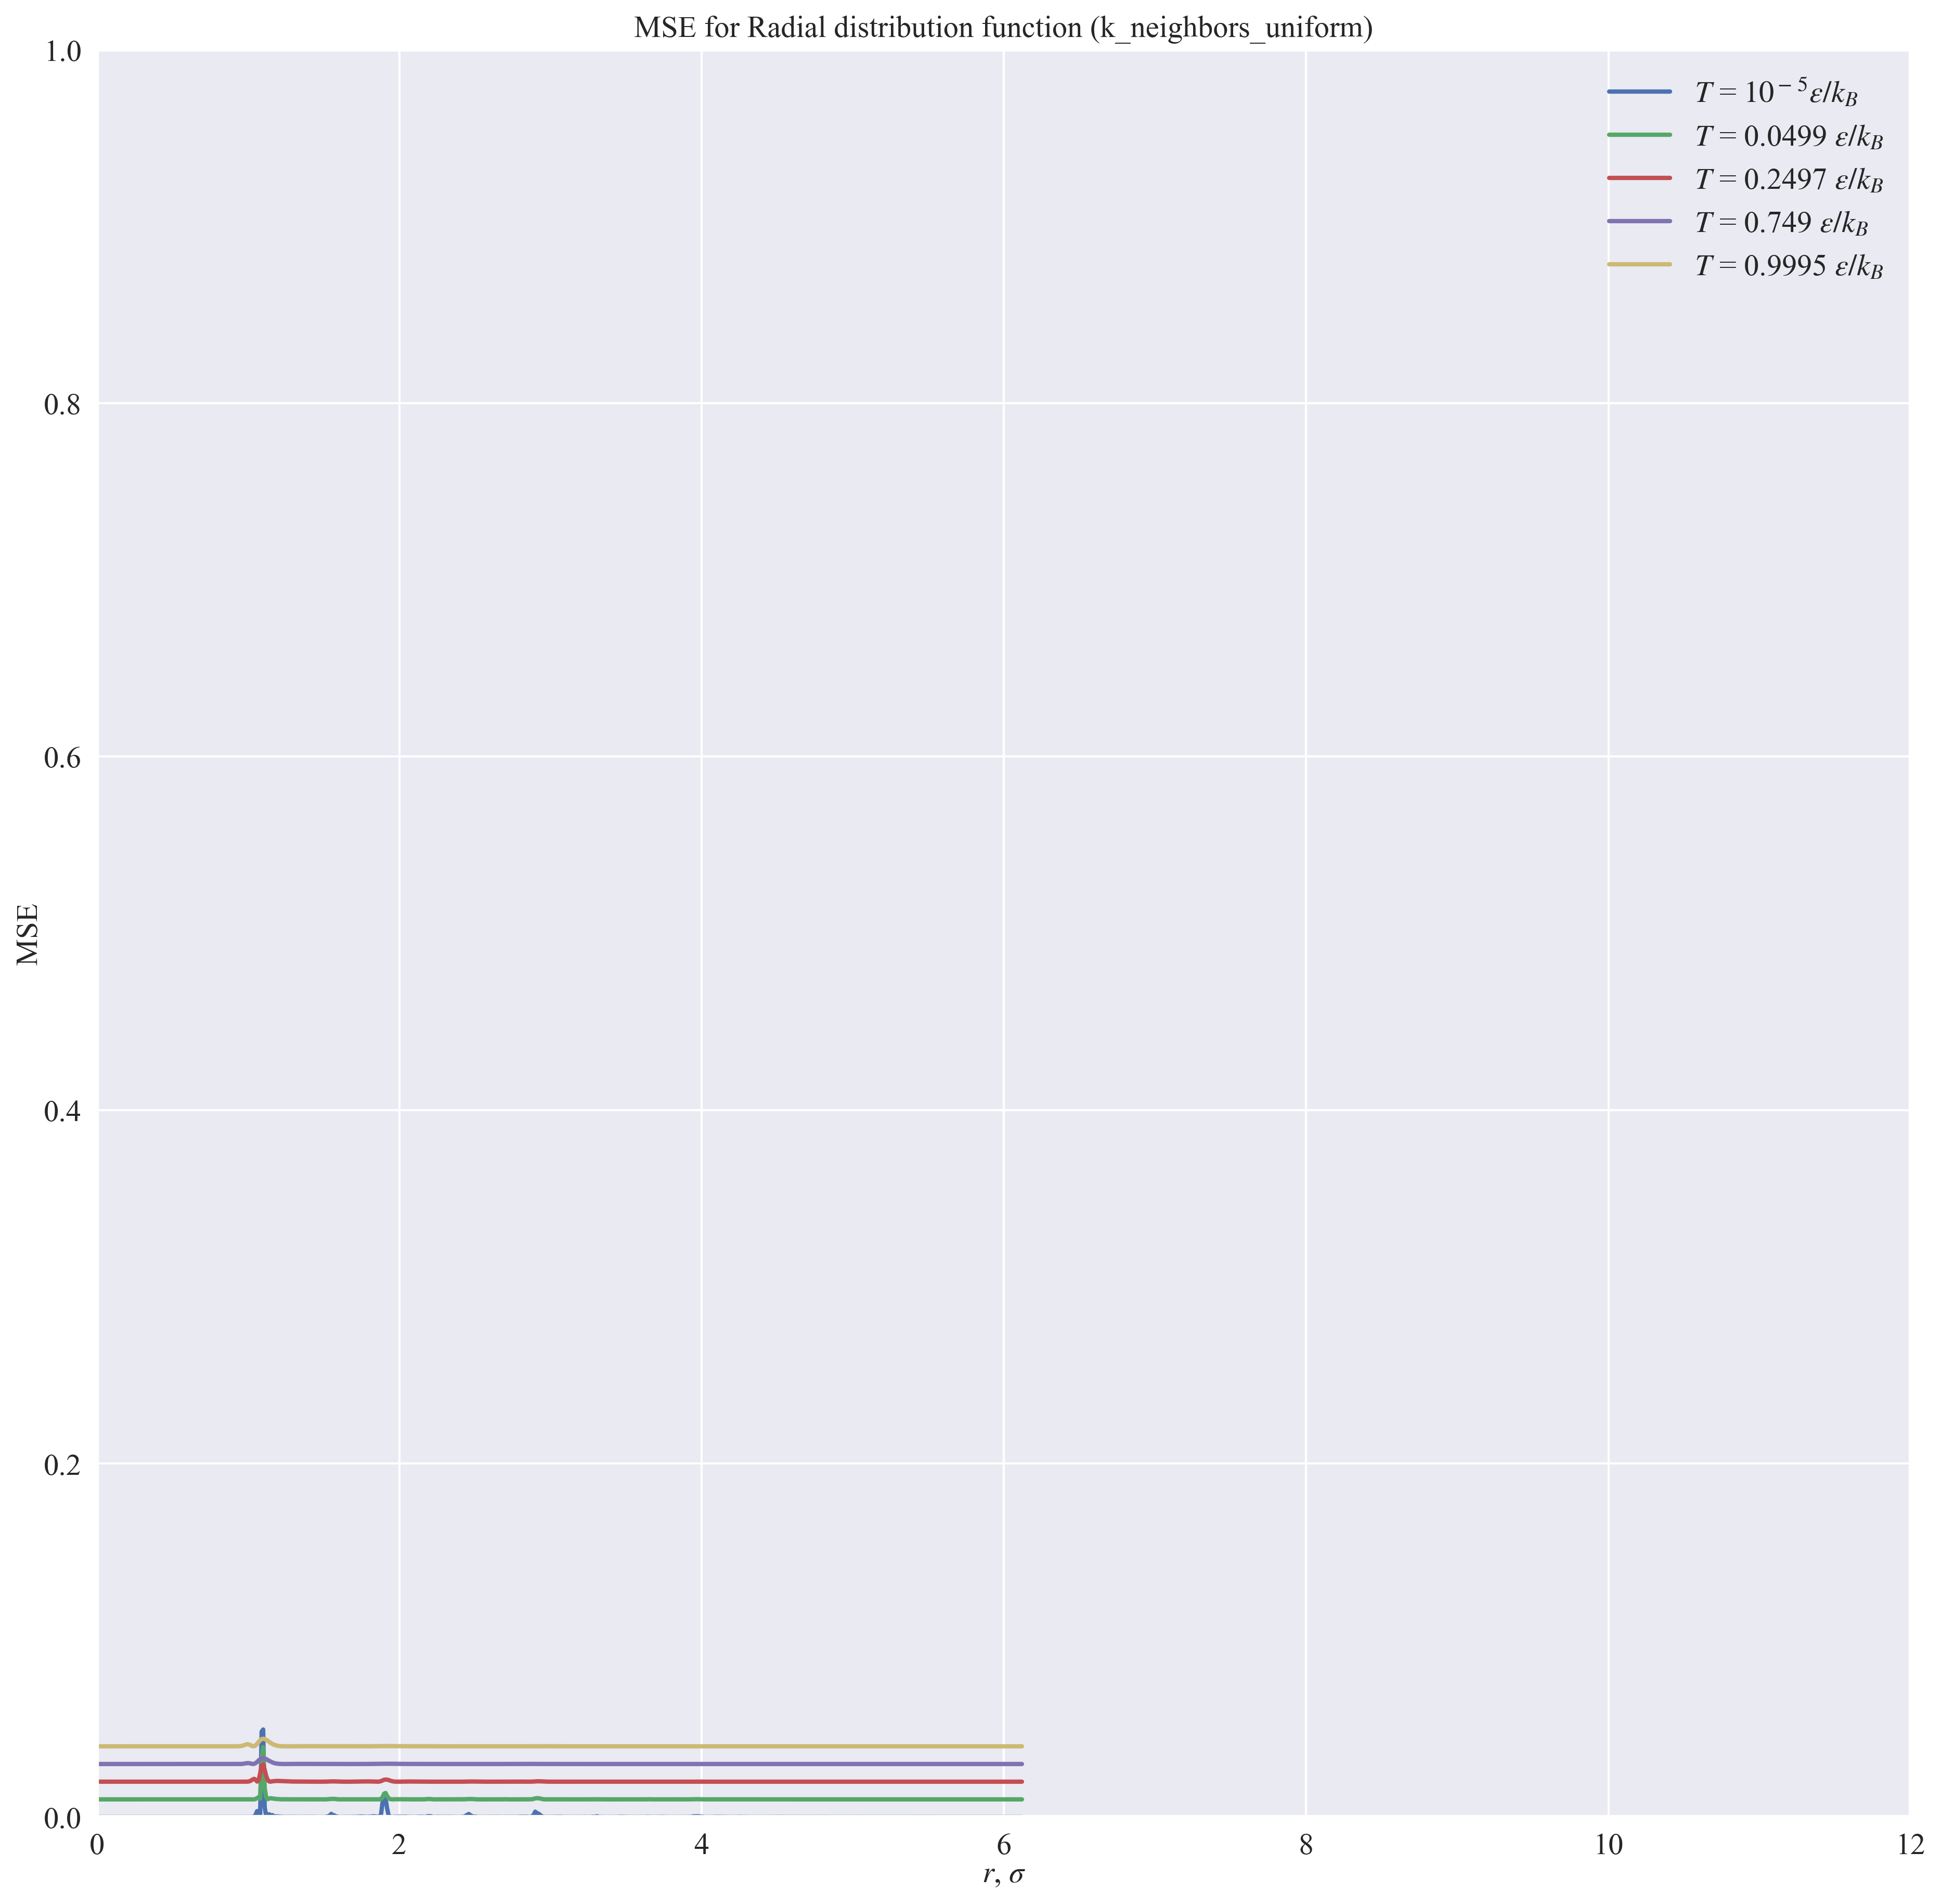

<Figure size 1771.65x1771.65 with 0 Axes>

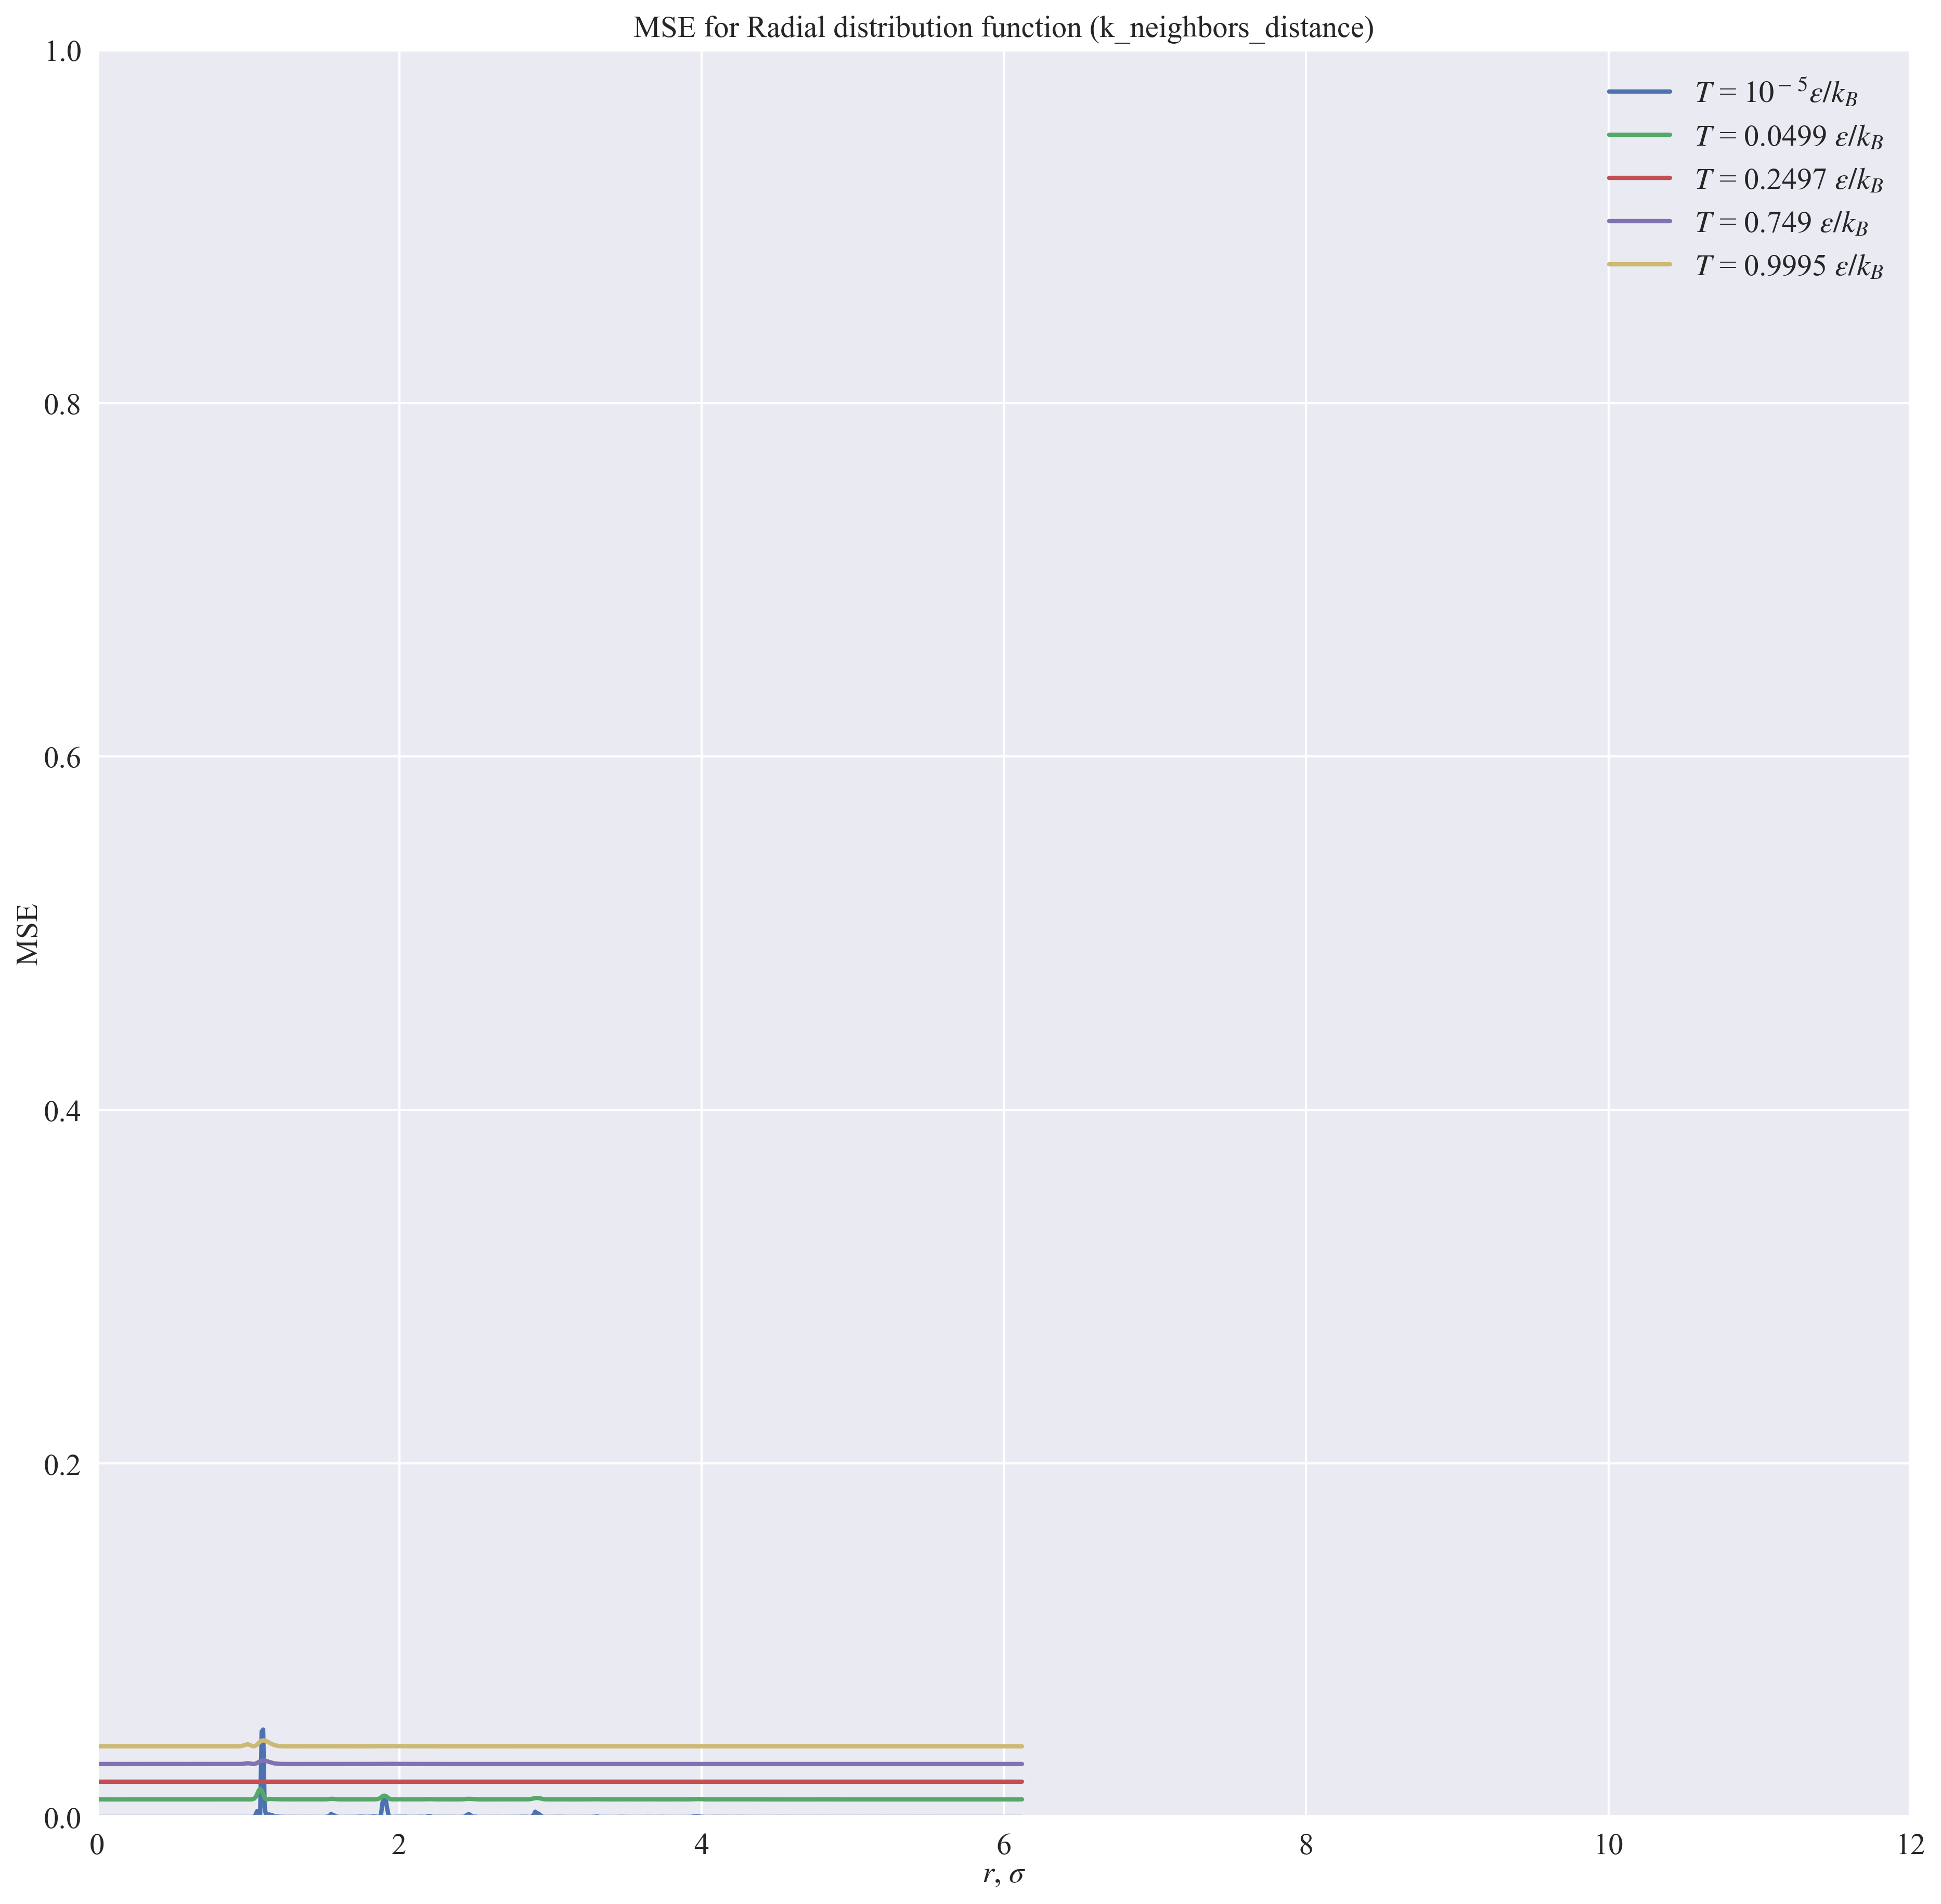

<Figure size 1771.65x1771.65 with 0 Axes>

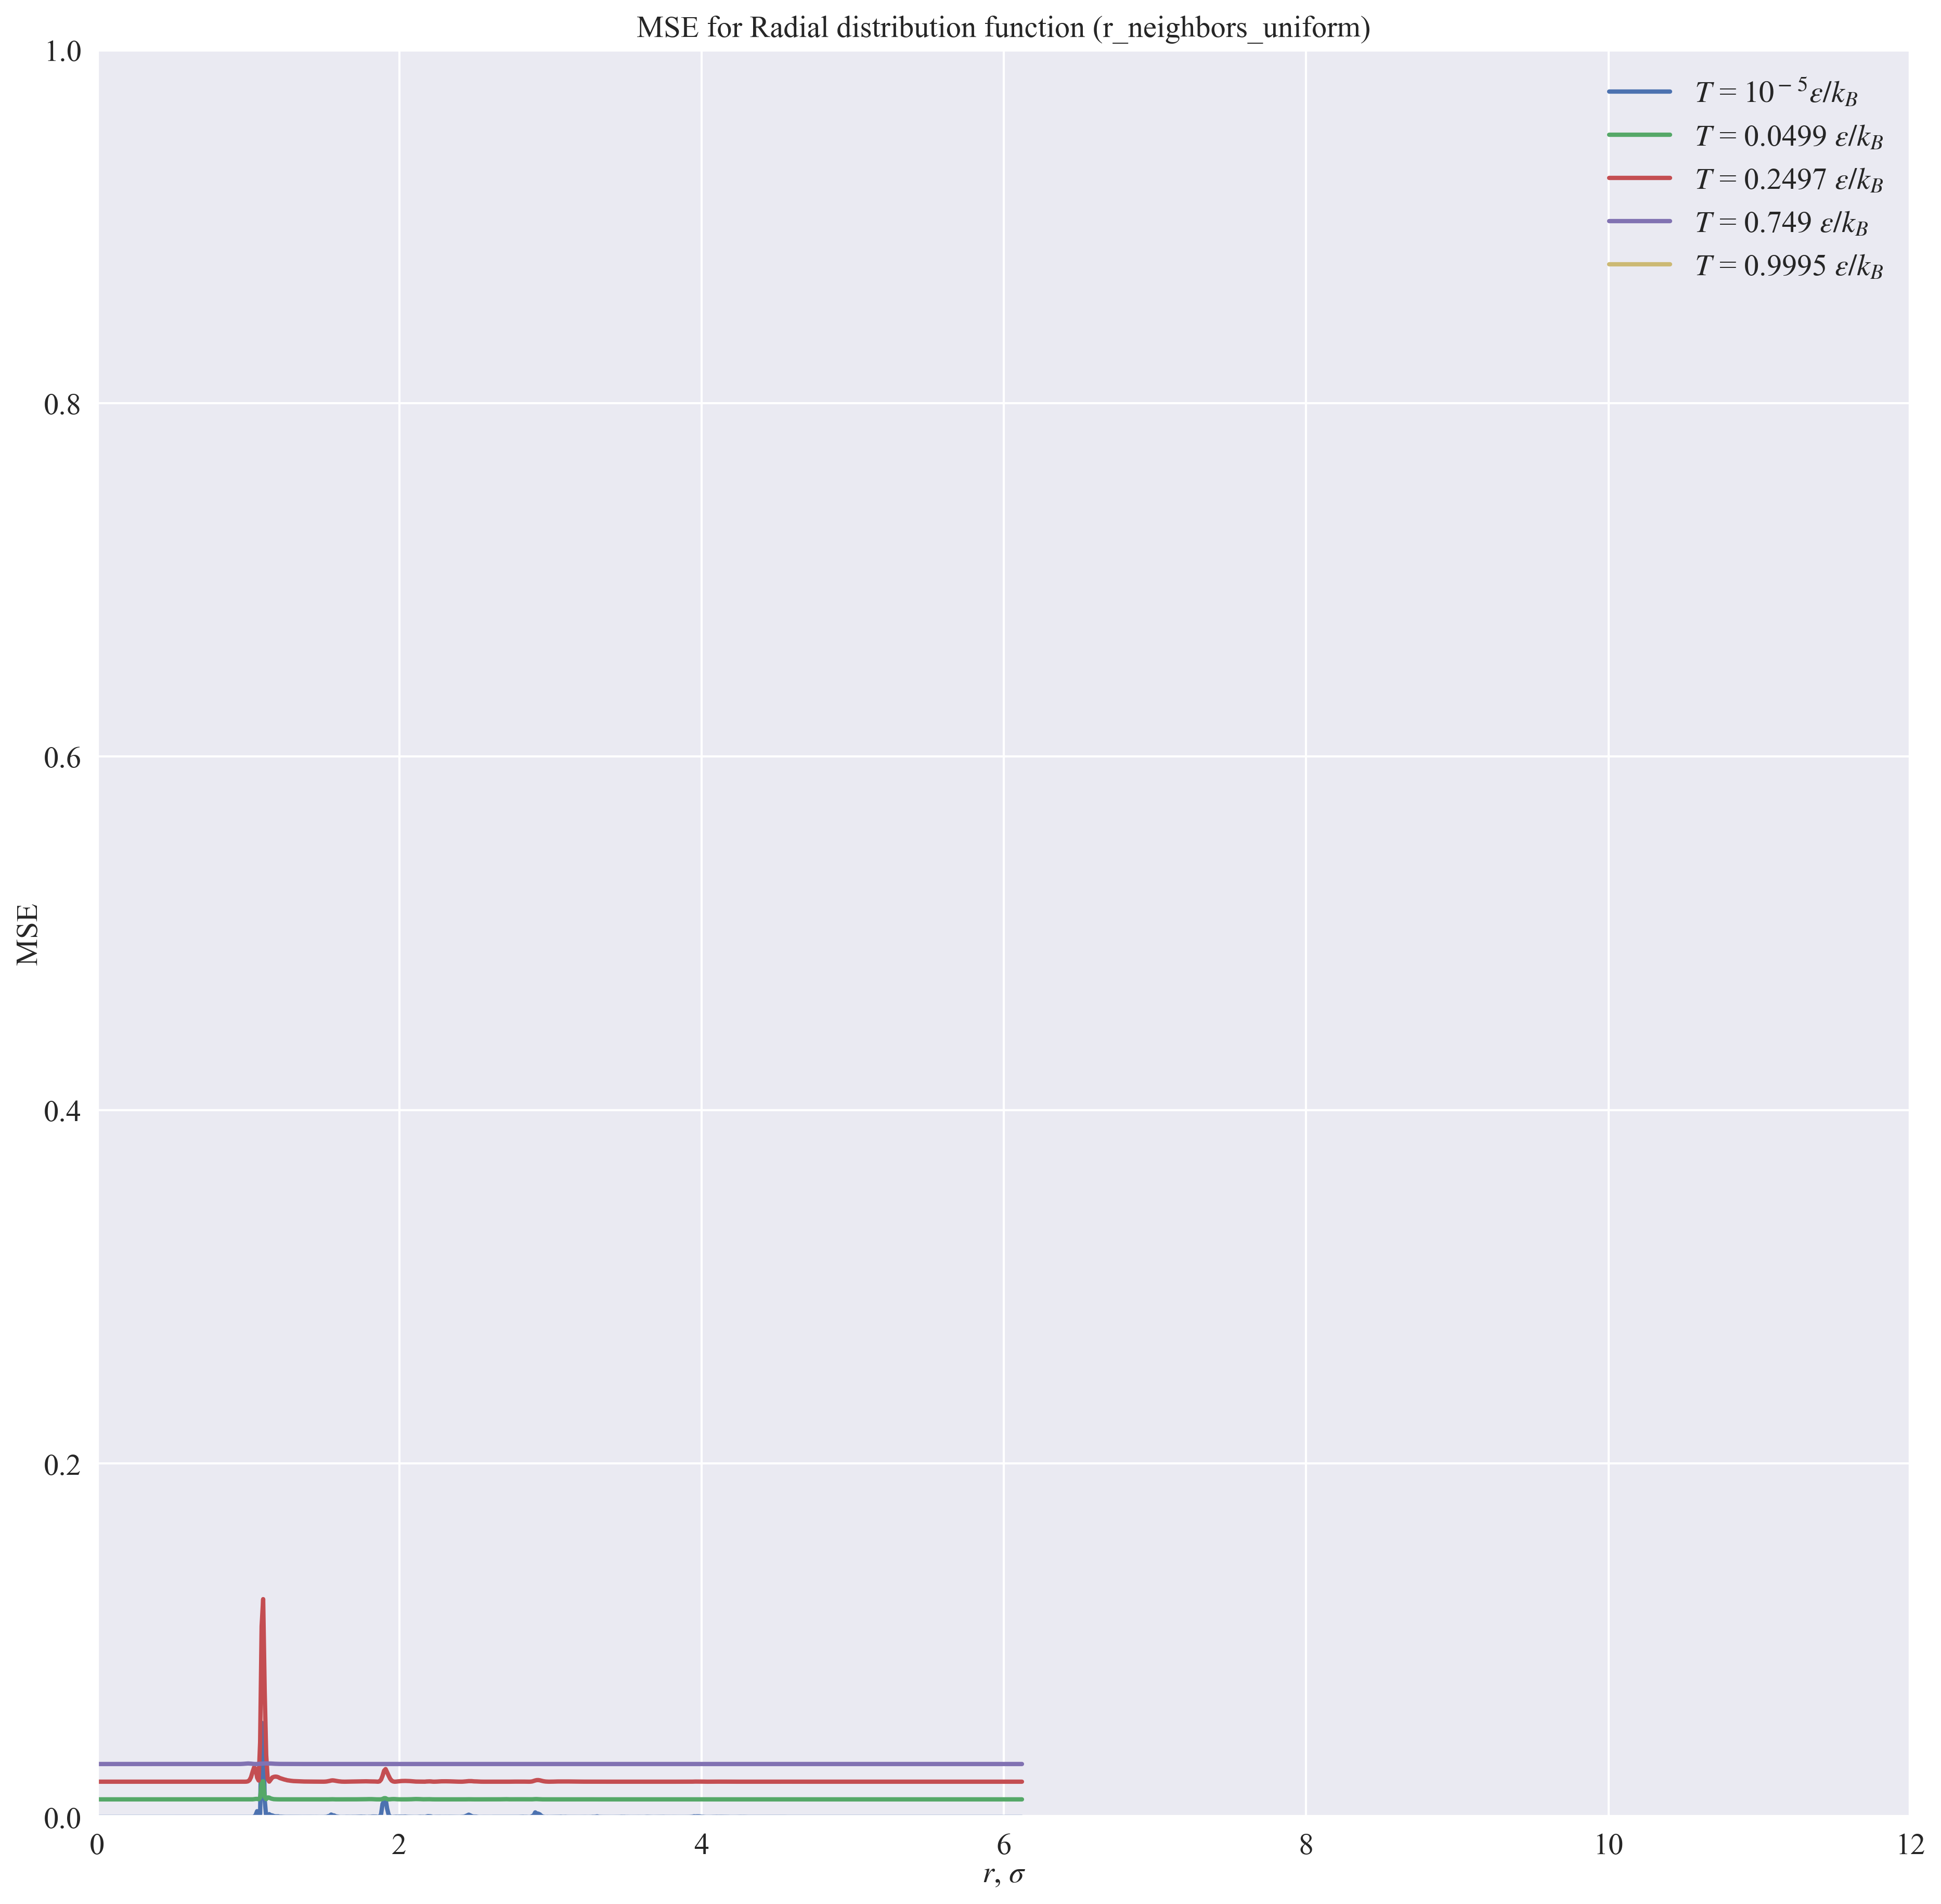

<Figure size 1771.65x1771.65 with 0 Axes>

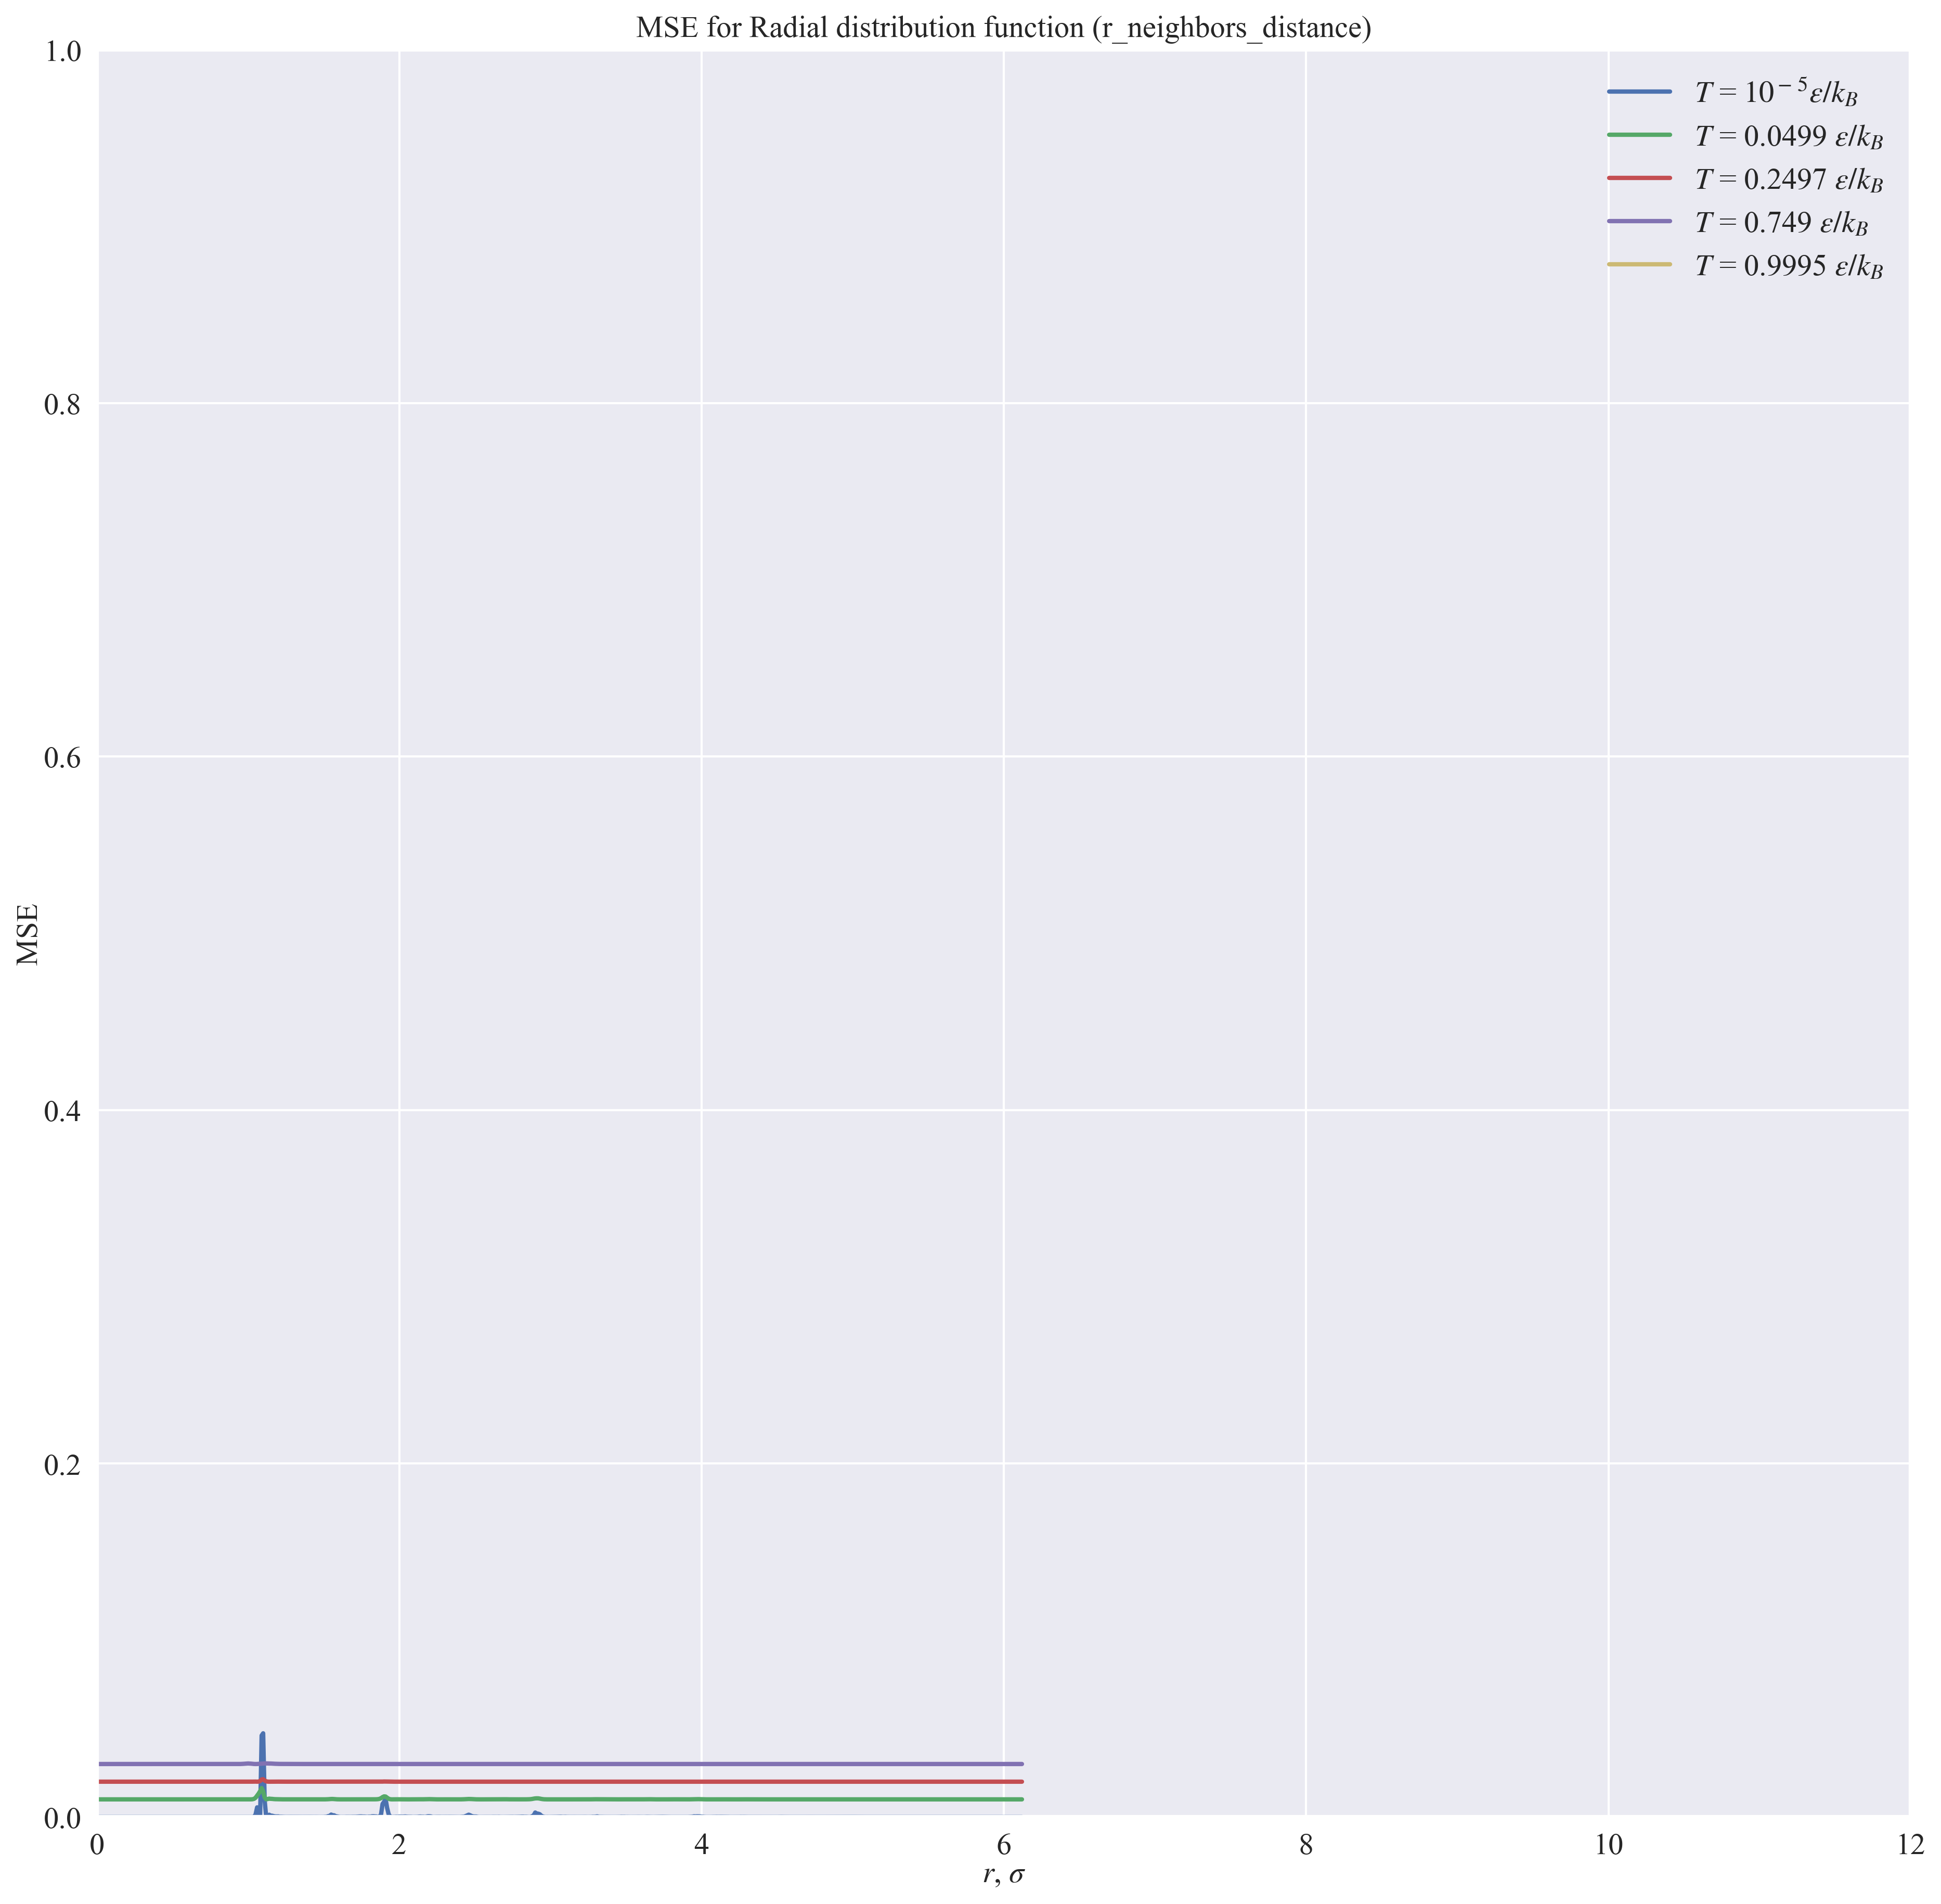

<Figure size 1771.65x1771.65 with 0 Axes>

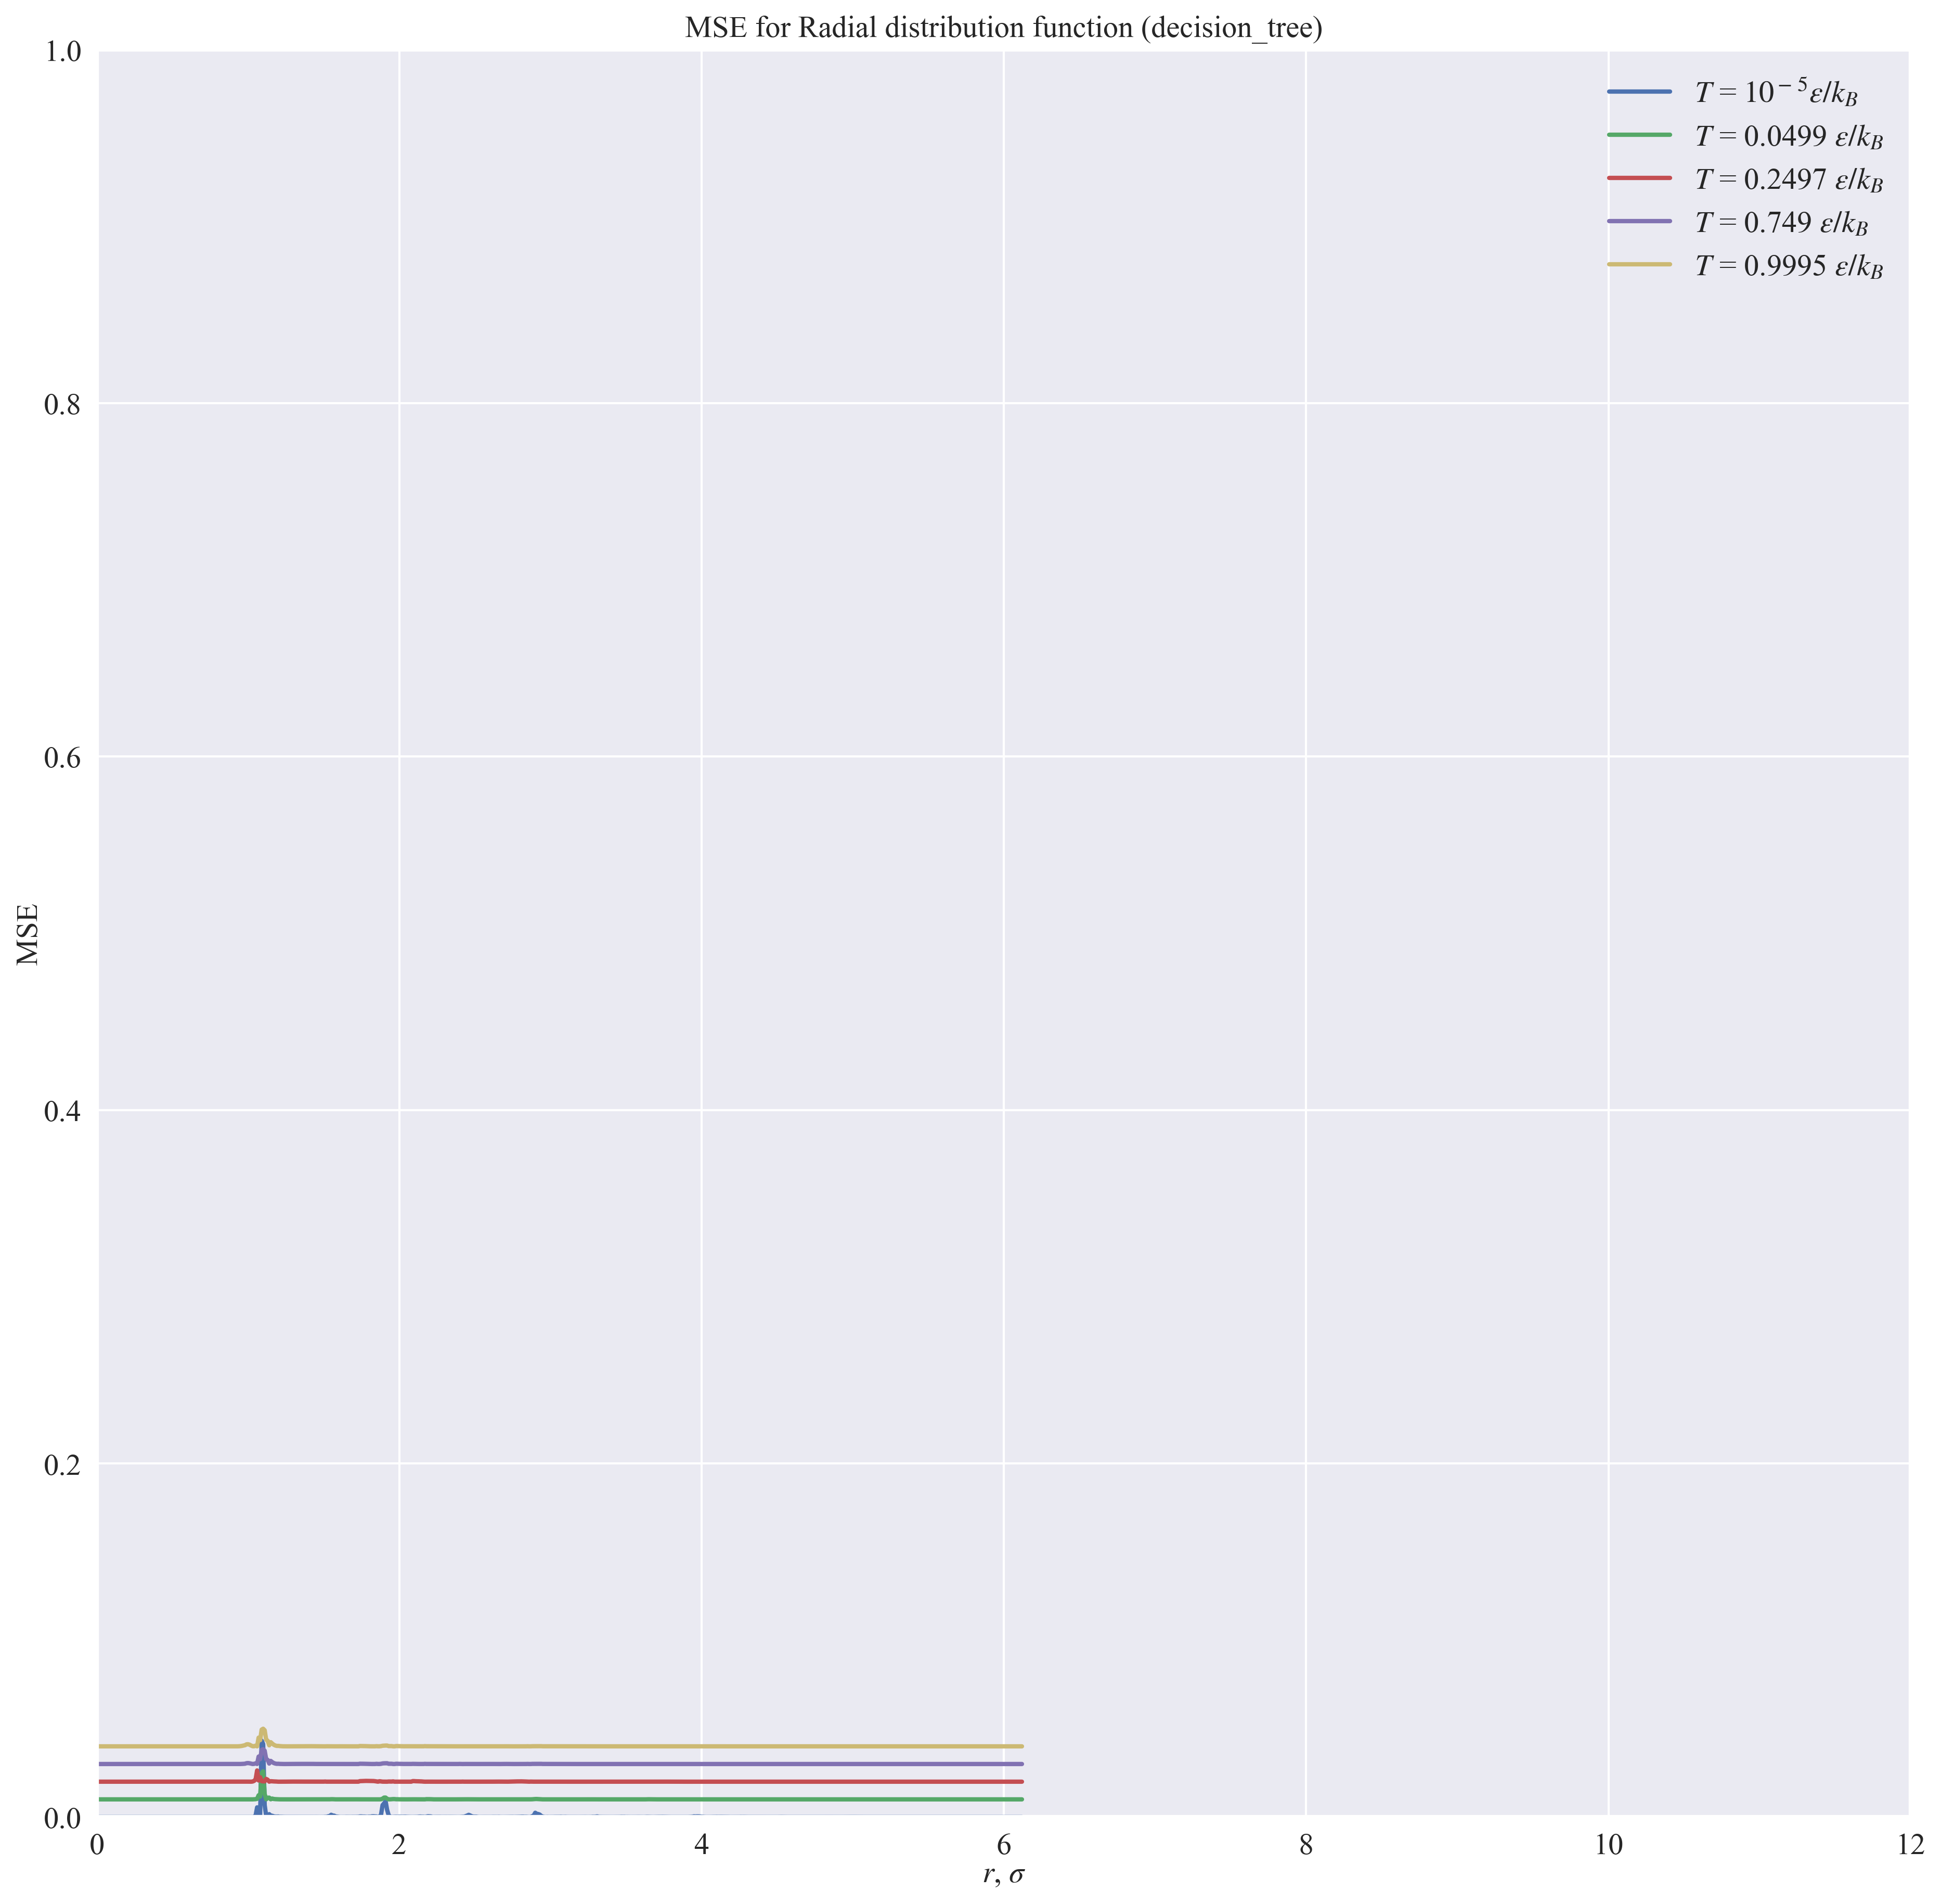

<Figure size 1771.65x1771.65 with 0 Axes>

In [24]:
max_mse = {
    'names': [],
}

for key, value in predicted_rdf_points.items():
    name = ''.join([item[0].upper() for item in key.split('_')])
    max_mse['names'].append(name)
    
    plotter = Plotter(
        path_to_plots=PATH_TO_CURRENT_PLOTS,
        limits=dict(
            left=0,
            right=12,
#             bottom=-1,
#             top=14,
        ),
        size=(15, 15),
        labels=('radius', 'MSE'),
    )
    plotter.ax.set_title(f'MSE for Radial distribution function ({key})')
    
    shown_temperatures = []
    for i, setup in enumerate(setups_slow):
        temperature = setup["temperature"]
        if temperature not in predicted_temperatures:
            continue
        if round(temperature, 4) in shown_temperatures:
            continue
        else:
            mse = (
                value[temperature]
                - rdf_slow.data[f'setup_{i}']
            ) ** 2 / rdf_table.columns.values.size
            try:
                max_mse[temperature].append(mse.max())
            except KeyError:
                max_mse[temperature] = [mse.max()]
            plotter.ax.plot(
                rdf_table.columns.values,
                mse + 0.01 * len(shown_temperatures),
                label=get_temperature_legend(temperature, 4),
            )
            shown_temperatures.append(round(temperature, 4))

    plotter.ax.legend()
    plotter.save_plot(f'rdf_mse_cooling_{key}.png')
    plt.show()
    save_plot(f'rdf_mse_cooling_{key}.png')
    plt.show()

In [25]:
max_mse['names']

['L', 'KNU', 'KND', 'RNU', 'RND', 'DT']

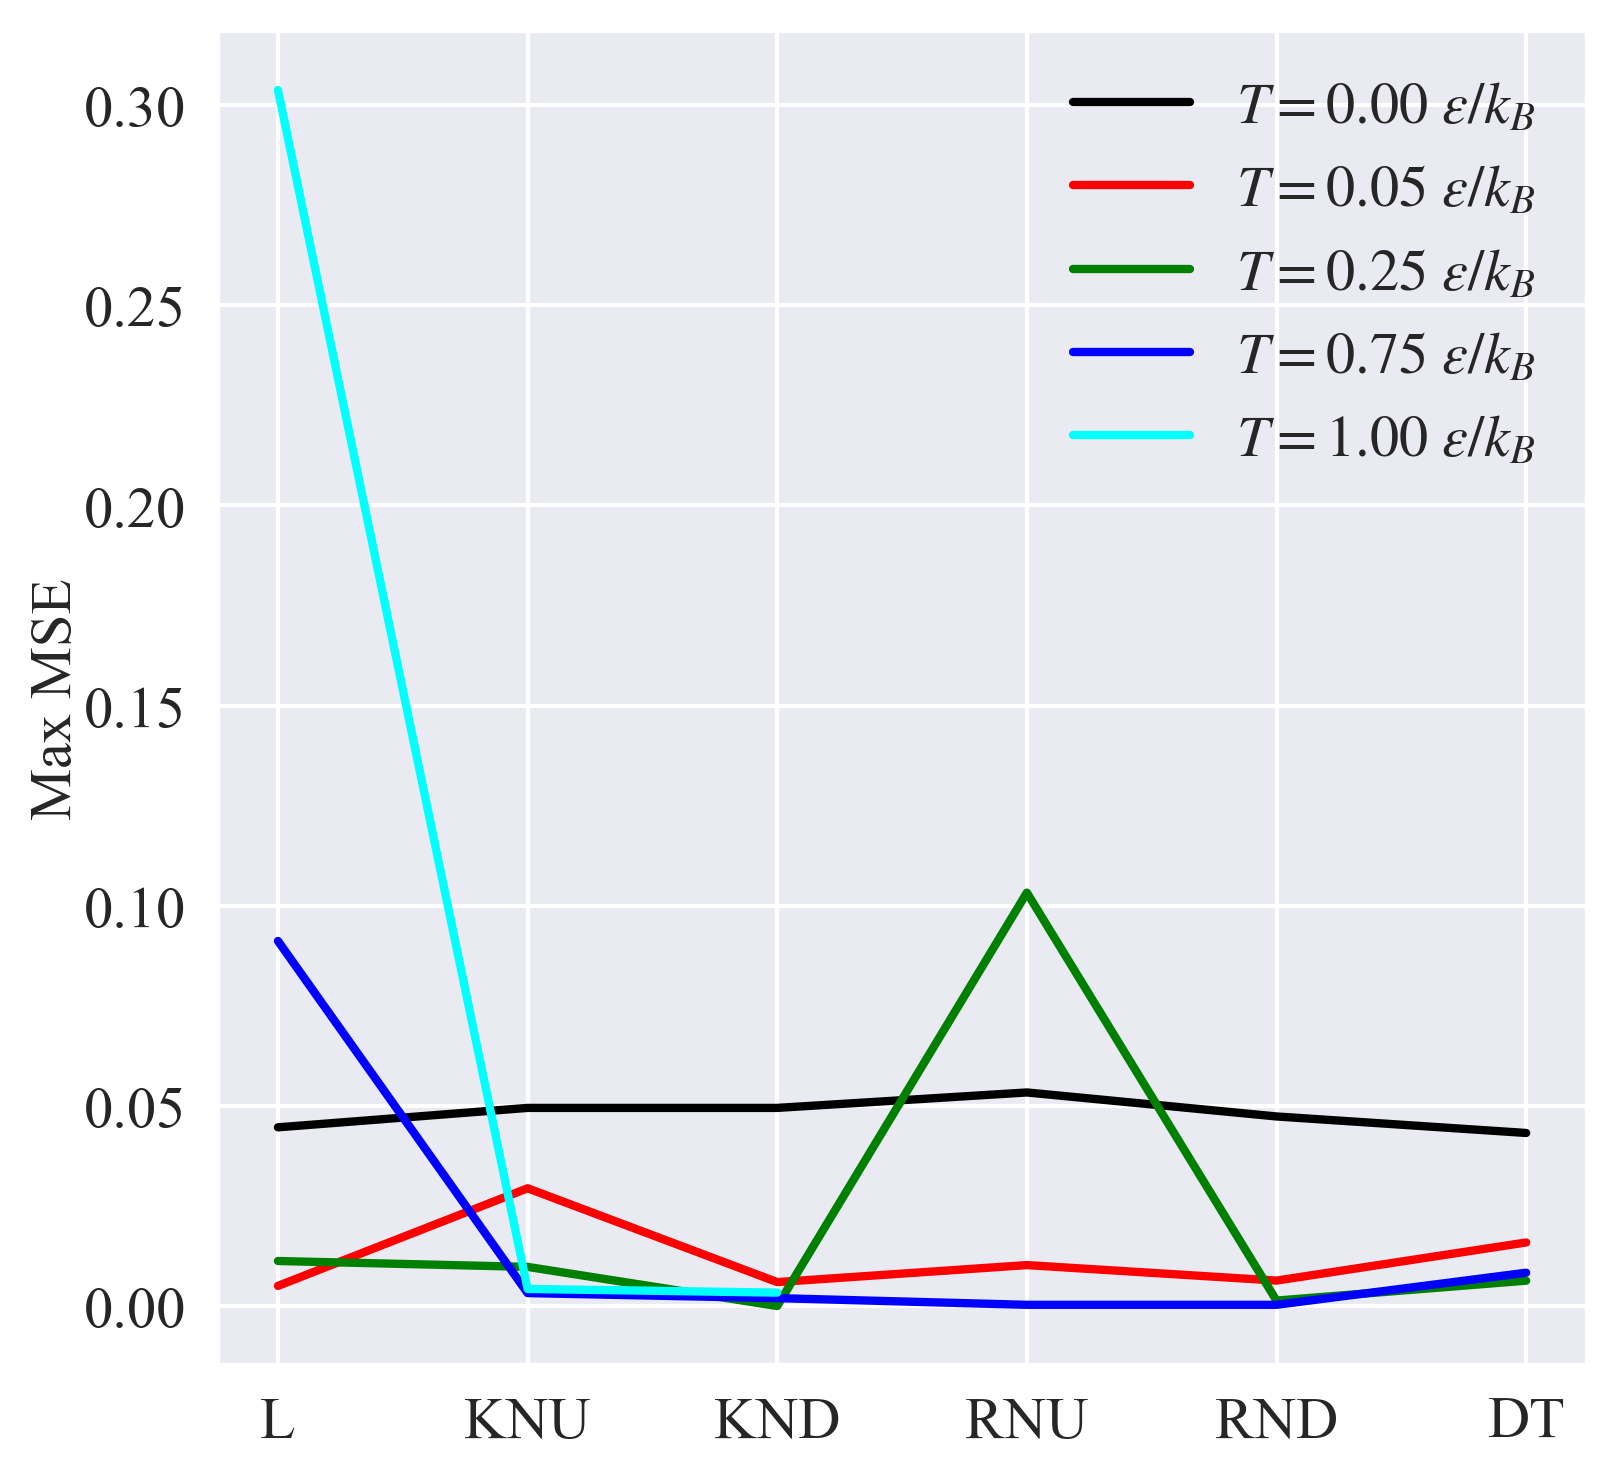

In [26]:
fig, ax = plt.subplots()
i = 0
for temperature, values in max_mse.items():
    if isinstance(temperature, float):
        x = list(range(len(values)))
        ax.plot(x, values, label=fr'$T = {temperature:.2f}~\epsilon / k_B$', color=COLORS[i])
        i += 1
        ax.set_xticks(x)
        ax.set_xticklabels(max_mse['names'])
        ax.set_ylabel('Max MSE')
        ax.legend()
        save_plot(f'max_mse.png')